# Prueba de datos

🔍 Buscando datos desde: c:\Users\Equipo\Desktop\Machine_DL...
✅ ¡ENCONTRADO!
📄 Archivo CSV: ..\petfinder-adoption-prediction\train\train.csv
📂 Carpeta base de datos: ..\petfinder-adoption-prediction

MASCOTA: Marley (ID: 1c6aa4b33)
Raza:    Poodle
Target:  2


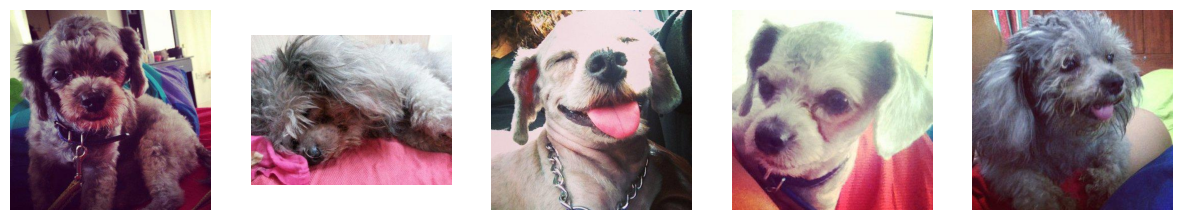

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

current_dir = os.getcwd()
search_start = ".." # Sube un nivel


print(f"🔍 Buscando datos desde: {os.path.abspath(search_start)}...")

train_path = None
root_data_folder = None

# Recorremos buscando 'train.csv'
for root, dirs, files in os.walk(search_start):
    if "train.csv" in files:
        train_path = os.path.join(root, "train.csv")
        if os.path.basename(root) == 'train':
            root_data_folder = os.path.dirname(root)
        else:
            root_data_folder = root
        
        print(f"✅ ¡ENCONTRADO!")
        print(f"📄 Archivo CSV: {train_path}")
        print(f"📂 Carpeta base de datos: {root_data_folder}")
        break

if not train_path:
    raise FileNotFoundError("❌ No se pudo localizar 'train.csv'. Asegúrate de que la carpeta 'petfinder-adoption-prediction' esté en Machine_DL.")


BREED_CSV_PATH = os.path.join(root_data_folder, 'breed_labels.csv')
COLOR_CSV_PATH = os.path.join(root_data_folder, 'color_labels.csv')
TRAIN_IMG_DIR  = os.path.join(root_data_folder, 'train_images') #


train = pd.read_csv(train_path)
breeds = pd.read_csv(BREED_CSV_PATH)
colors = pd.read_csv(COLOR_CSV_PATH)

# --- FUNCIONES DE APOYO ---
breed_dict = dict(zip(breeds['BreedID'], breeds['BreedName']))
def get_breed_name(breed_id):
    return breed_dict.get(breed_id, "Desconocido")

def visualizar_mascota(pet_id=None):
    if pet_id is None:
        pet_id = train.sample(1)['PetID'].values[0]
    
    pet_data = train[train['PetID'] == pet_id].iloc[0]
    
    print(f"\n{'='*40}")
    print(f"MASCOTA: {pet_data['Name']} (ID: {pet_id})")
    print(f"Raza:    {get_breed_name(pet_data['Breed1'])}")
    print(f"Target:  {pet_data['AdoptionSpeed']}")
    
    # Buscar imágenes en la carpeta detectada
    if os.path.exists(TRAIN_IMG_DIR):
        images = [f for f in os.listdir(TRAIN_IMG_DIR) if str(pet_id) in f and f.endswith('.jpg')]
        images.sort()
        
        if images:
            plt.figure(figsize=(15, 5))
            for i, img_file in enumerate(images[:5]):
                img_path = os.path.join(TRAIN_IMG_DIR, img_file)
                img = mpimg.imread(img_path)
                plt.subplot(1, 5, i + 1)
                plt.imshow(img)
                plt.axis('off')
            plt.show()
        else:
            print(">> No hay fotos para esta mascota.")
    else:
        print(f">> Carpeta de imágenes no encontrada en: {TRAIN_IMG_DIR}")

# ---EJECUTAR ---
visualizar_mascota()

# Estructura de datos y creación de un DataFrame

### Analisis del Dataset 

Primero analizamos el dataset de imagenes para la distribucion de las mismas y contemplar una posible reestructuración, ya sea de dimensiones, calidad o de número de imágenes, para que puedan ser procesadas correctamente.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import shutil
from sklearn.model_selection import train_test_split
from tqdm import tqdm  # Librería para ver barra de progreso

# ==========================================
# PARTE 1: LOCALIZACIÓN DE DATOS (Tu código original)
# ==========================================

current_dir = os.getcwd()
search_start = ".." # Sube un nivel

print(f"🔍 Buscando datos desde: {os.path.abspath(search_start)}...")

train_path = None
root_data_folder = None

# Recorremos buscando 'train.csv'
for root, dirs, files in os.walk(search_start):
    if "train.csv" in files:
        train_path = os.path.join(root, "train.csv")
        if os.path.basename(root) == 'train':
            root_data_folder = os.path.dirname(root)
        else:
            root_data_folder = root
        
        print(f"✅ ¡ENCONTRADO!")
        print(f"📄 Archivo CSV: {train_path}")
        print(f"📂 Carpeta base de datos: {root_data_folder}")
        break

if not train_path:
    raise FileNotFoundError("❌ No se pudo localizar 'train.csv'.")

BREED_CSV_PATH = os.path.join(root_data_folder, 'breed_labels.csv')
COLOR_CSV_PATH = os.path.join(root_data_folder, 'color_labels.csv')
TRAIN_IMG_DIR  = os.path.join(root_data_folder, 'train_images')

# Cargar datos
train = pd.read_csv(train_path)

# ==========================================
# PARTE 2: PREPARACIÓN Y DIVISIÓN DE DATOS
# ==========================================
print("\n📊 Preparando división de datos (Train / Test)...")

# Dividimos el CSV en Train (80%) y Test (20%) manteniendo la proporción de clases (AdoptionSpeed)
train_df, test_df = train_test_split(
    train, 
    test_size=0.2, 
    stratify=train['AdoptionSpeed'], 
    random_state=42
)

print(f"   -> Imágenes para Train: {len(train_df)}")
print(f"   -> Imágenes para Test:  {len(test_df)}")

# ==========================================
# PARTE 3: CREACIÓN DE ESTRUCTURA EN DRIVE
# ==========================================

# Tu ruta de destino en G:
base_nombre = 'datos tratados'
base_path_superior = os.path.join(r'G:\Mi unidad\Mascotas', base_nombre)

# Función optimizada para copiar
def copiar_imagenes_dataset(df, carpeta_destino_base, nombre_conjunto):
    print(f"\n🚀 Procesando conjunto: {nombre_conjunto} -> {carpeta_destino_base}")
    
    # Crear carpetas 0, 1, 2, 3, 4
    clases = ['0', '1', '2', '3', '4']
    for clase in clases:
        os.makedirs(os.path.join(carpeta_destino_base, clase), exist_ok=True)
    
    copiadas = 0
    faltantes = 0
    
    # Iteramos con barra de progreso
    for _, row in tqdm(df.iterrows(), total=len(df), unit="mascota"):
        pet_id = row['PetID']
        adop_speed = str(row['AdoptionSpeed'])
        
        # En PetFinder, una mascota puede tener varias fotos: PetID-1.jpg, PetID-2.jpg...
        # Buscamos patrones que empiecen por el PetID
        # NOTA: Esto asume que tienes las imágenes descomprimidas en TRAIN_IMG_DIR
        
        # Estrategia rápida: Intentar copiar la foto 1 (la principal)
        # Si quieres TODAS las fotos, el código se complica un poco más buscando archivos, 
        # pero para entrenar modelos, a veces basta con la primera o las primeras 3.
        # Aquí intentaremos copiar TODAS las que existan secuencialmente.
        
        encontro_alguna = False
        for i in range(1, 10): # Busca foto -1, -2 ... hasta -9
            nombre_foto = f"{pet_id}-{i}.jpg"
            ruta_origen = os.path.join(TRAIN_IMG_DIR, nombre_foto)
            
            if os.path.exists(ruta_origen):
                ruta_destino = os.path.join(carpeta_destino_base, adop_speed, nombre_foto)
                
                # Copiar solo si no existe ya
                if not os.path.exists(ruta_destino):
                    shutil.copy2(ruta_origen, ruta_destino)
                
                copiadas += 1
                encontro_alguna = True
            else:
                # Si no existe la -1, es raro, pero si no existe la -3 dejamos de buscar para esta mascota
                if i == 1: 
                    pass # La foto principal falta
                else: 
                    break # Se acabaron las fotos de esta mascota
        
        if not encontro_alguna:
            faltantes += 1

    print(f"✅ Finalizado {nombre_conjunto}: {copiadas} fotos copiadas. ({faltantes} mascotas sin fotos)")

# --- EJECUCIÓN DE LA COPIA ---

if os.path.exists(TRAIN_IMG_DIR):
    # Crear rutas de destino
    train_dest = os.path.join(base_path_superior, 'Train')
    test_dest = os.path.join(base_path_superior, 'Test')

    # Ejecutar
    copiar_imagenes_dataset(train_df, train_dest, "TRAIN")
    copiar_imagenes_dataset(test_df, test_dest, "TEST")
    
    print(f"\n✨ ¡Proceso completo! Revisa tu carpeta en: {base_path_superior}")
else:
    print(f"❌ ERROR CRÍTICO: No encuentro la carpeta de imágenes origen en: {TRAIN_IMG_DIR}")
    print("Asegúrate de haber descomprimido el archivo train_images.zip de Kaggle en esa carpeta.")

🔍 Buscando datos desde: c:\Users\Equipo\Desktop\Machine_DL...
✅ ¡ENCONTRADO!
📄 Archivo CSV: ..\petfinder-adoption-prediction\train\train.csv
📂 Carpeta base de datos: ..\petfinder-adoption-prediction

📊 Preparando división de datos (Train / Test)...
   -> Imágenes para Train: 11994
   -> Imágenes para Test:  2999

🚀 Procesando conjunto: TRAIN -> G:\Mi unidad\Mascotas\datos tratados\Train


100%|██████████| 11994/11994 [2:49:32<00:00,  1.18mascota/s]  


✅ Finalizado TRAIN: 42840 fotos copiadas. (273 mascotas sin fotos)

🚀 Procesando conjunto: TEST -> G:\Mi unidad\Mascotas\datos tratados\Test


100%|██████████| 2999/2999 [18:47<00:00,  2.66mascota/s]  

✅ Finalizado TEST: 10702 fotos copiadas. (68 mascotas sin fotos)

✨ ¡Proceso completo! Revisa tu carpeta en: G:\Mi unidad\Mascotas\datos tratados


✅ Analizando datos en: c:\Users\Equipo\Desktop\Machine_DL\datos tratados


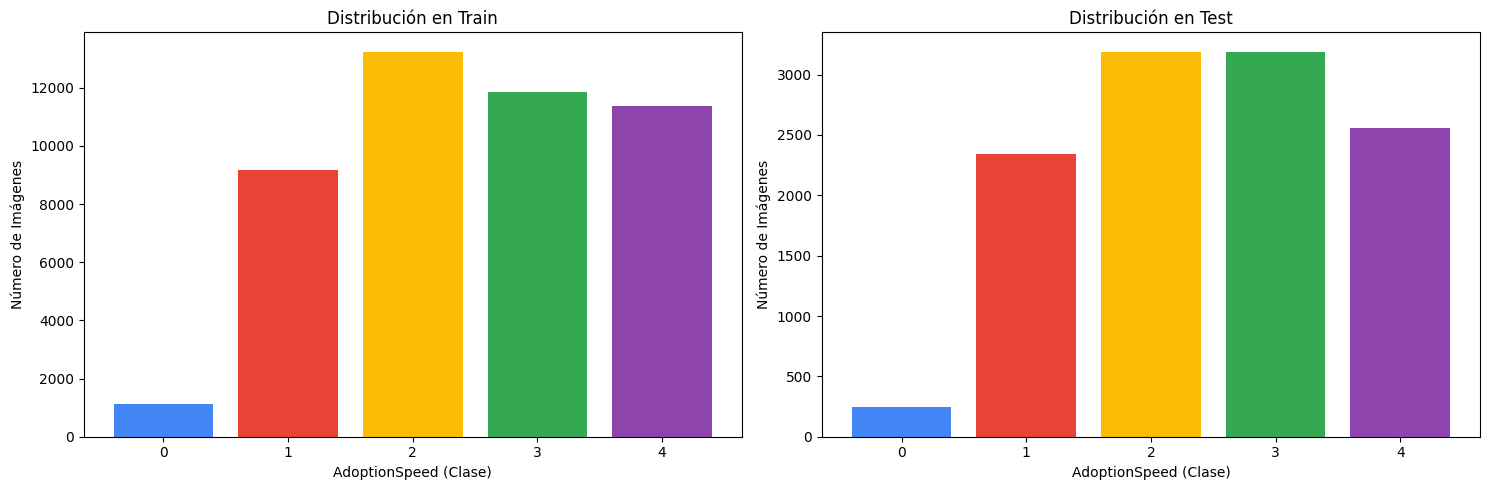

In [ ]:
import matplotlib.pyplot as plt
import os
import seaborn as sns # Añadimos seaborn para que los gráficos se vean más modernos

def graficar_distribucion(nombre_carpeta='datos tratados'):
    # 1. Detección de ruta
    if os.path.exists(nombre_carpeta):
        base_path = nombre_carpeta
    elif os.path.exists(os.path.join(r'G:\Mi unidad\Mascotas', nombre_carpeta)):
        base_path = os.path.join(r'G:\Mi unidad\Mascotas', nombre_carpeta) 
    else:
        print(f"❌ No se encuentra la carpeta '{nombre_carpeta}'")
        return

    print(f"✅ Analizando datos en: {os.path.abspath(base_path)}")

    sets = ['Train', 'Test']
    clases = ['0', '1', '2', '3', '4']
    colores = ['#4285F4', '#EA4335', '#FBBC05', '#34A853', '#8E44AD']
    
    fig, ax = plt.subplots(1, 2, figsize=(15, 6)) # Un poco más alto para que quepan los números
    
    for i, s in enumerate(sets):
        counts = []
        for c in clases:
            path = os.path.join(base_path, s, c)
            if os.path.exists(path):
                # Solo contamos archivos, no carpetas
                counts.append(len([f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]))
            else:
                counts.append(0)
        
        bars = ax[i].bar(clases, counts, color=colores, edgecolor='black', alpha=0.8)
        ax[i].set_title(f'Distribución en {s}', fontsize=14, fontweight='bold')
        ax[i].set_xlabel('AdoptionSpeed (Clase)', fontsize=12)
        ax[i].set_ylabel('Número de Imágenes', fontsize=12)
        ax[i].grid(axis='y', linestyle='--', alpha=0.6)
        
        # Añadir el número total encima de cada barra
        for bar in bars:
            height = bar.get_height()
            ax[i].annotate(f'{height}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # 3 puntos de offset vertical
                        textcoords="offset points",
                        ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()

graficar_distribucion()

🔍 Analizando subcarpetas en: G:\Mi unidad\Mascotas\datos tratados\Train
📁 Procesando clase 0 (1045 imágenes)...


100%|██████████| 1045/1045 [00:09<00:00, 107.57it/s]


📁 Procesando clase 1 (8672 imágenes)...


100%|██████████| 8672/8672 [01:26<00:00, 100.63it/s]


📁 Procesando clase 2 (12145 imágenes)...


100%|██████████| 12145/12145 [02:09<00:00, 93.83it/s] 


📁 Procesando clase 3 (10614 imágenes)...


100%|██████████| 10614/10614 [01:27<00:00, 121.66it/s]


📁 Procesando clase 4 (10364 imágenes)...


100%|██████████| 10364/10364 [01:40<00:00, 103.42it/s]


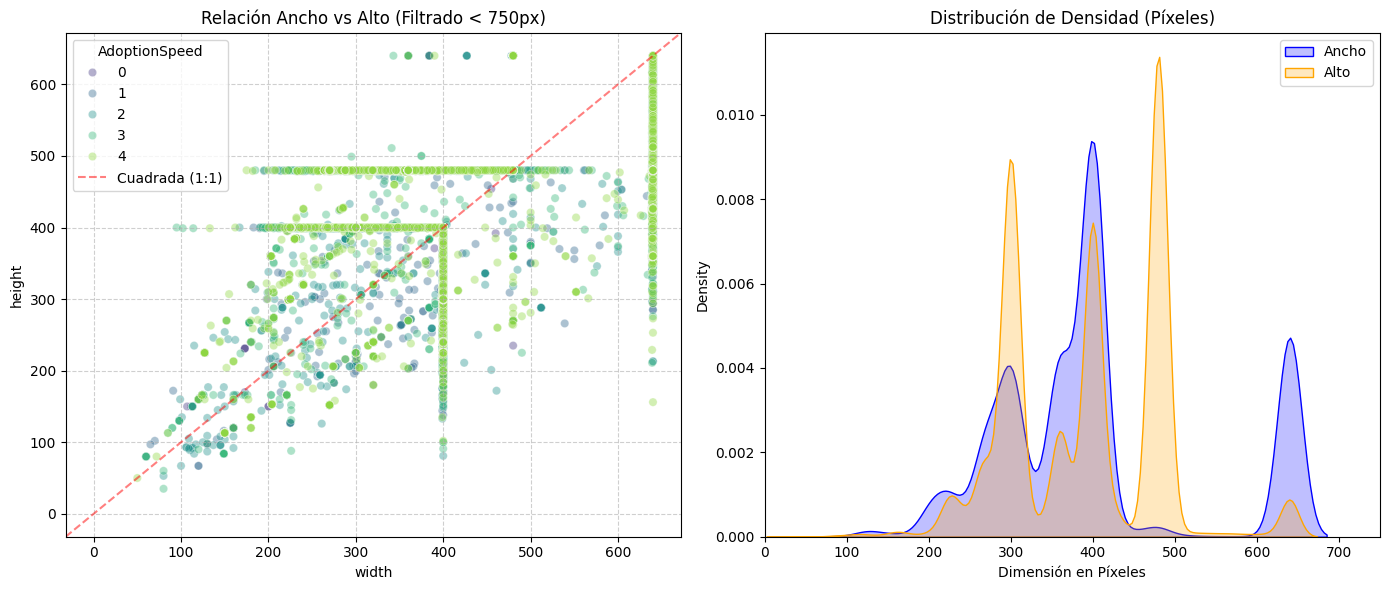


📊 Resumen de Resoluciones (Sin Outliers):
              width        height
count  42839.000000  42839.000000
mean     399.001704    390.319172
std      126.332044     93.350147
min       50.000000     35.000000
25%      300.000000    300.000000
50%      400.000000    400.000000
75%      400.000000    480.000000
max      640.000000    640.000000

📏 Relación de aspecto media: 1.07

📈 Imágenes analizadas por clase:
class
0     1045
1     8672
2    12145
3    10614
4    10363
Name: count, dtype: int64


In [27]:
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm # Importante para ver el progreso en Drive

# --- 1. CONFIGURACIÓN DE RUTAS ---
# Apuntamos a la base de datos tratada en Drive
directorio = r'G:\Mi unidad\Mascotas\datos tratados\Train'

if not os.path.exists(directorio):
    print(f"❌ Error: No se encuentra la carpeta en {os.path.abspath(directorio)}")
    raise FileNotFoundError

print(f"🔍 Analizando subcarpetas en: {os.path.abspath(directorio)}")

# --- 2. RECOLECCIÓN RECURSIVA DE DIMENSIONES ---
resoluciones = []

# Usamos os.walk para entrar en las carpetas 0, 1, 2, 3, 4
for root, dirs, files in os.walk(directorio):
    # Filtramos solo archivos JPG
    fotos = [f for f in files if f.lower().endswith(('.jpg', '.jpeg'))]
    
    if fotos:
        print(f"📁 Procesando clase {os.path.basename(root)} ({len(fotos)} imágenes)...")
        for archivo in tqdm(fotos):
            path_completo = os.path.join(root, archivo)
            try:
                # PIL.Image.open no carga la imagen entera en memoria, solo lee la cabecera
                with Image.open(path_completo) as img:
                    ancho, alto = img.size
                    resoluciones.append({
                        'width': ancho, 
                        'height': alto, 
                        'class': os.path.basename(root)
                    })
            except:
                continue

# Creamos el DataFrame
df_res = pd.DataFrame(resoluciones)

if df_res.empty:
    print("❌ No se encontraron imágenes. Verifica las rutas.")
else:
    # --- 3. FILTRO DE OUTLIERS (Límite 750px) ---
    df_res = df_res[(df_res['width'] <= 750) & (df_res['height'] <= 750)]

    # --- 4. VISUALIZACIÓN GRÁFICA ---
    plt.figure(figsize=(14, 6))

    # Subplot 1: Distribución Conjunta por Clase
    plt.subplot(1, 2, 1)
    sns.scatterplot(data=df_res, x='width', y='height', hue='class', alpha=0.4, palette='viridis')
    plt.title('Relación Ancho vs Alto (Filtrado < 750px)')
    plt.axline((0, 0), slope=1, color='red', linestyle='--', alpha=0.5, label='Cuadrada (1:1)')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(title='AdoptionSpeed')

    # Subplot 2: Histogramas de densidad
    plt.subplot(1, 2, 2)
    sns.kdeplot(data=df_res, x='width', fill=True, color='blue', label='Ancho')
    sns.kdeplot(data=df_res, x='height', fill=True, color='orange', label='Alto')
    plt.title('Distribución de Densidad (Píxeles)')
    plt.xlabel('Dimensión en Píxeles')
    plt.xlim(0, 750)
    plt.legend()

    plt.tight_layout()
    plt.show()

    # --- 5. ESTADÍSTICAS ---
    print("\n📊 Resumen de Resoluciones (Sin Outliers):")
    print(df_res[['width', 'height']].describe())

    df_res['aspect_ratio'] = df_res['width'] / df_res['height']
    print(f"\n📏 Relación de aspecto media: {df_res['aspect_ratio'].mean():.2f}")
    
    # Conteo por clase para verificar balance
    print("\n📈 Imágenes analizadas por clase:")
    print(df_res['class'].value_counts().sort_index())

Definimos una posible forma de data augmentation para nuestro dataset. Por ahora no la vamos a usar ya que no es necesario.

## Reestructuración del Dataset

Después de analizar el dataset, se ha decidido reestructurarlo para que sea más fácil de manejar y para que sea más fácil de entrenar el modelo. Creamos una carpeta llamada reestructured_dataset que contiene las imágenes reescaladas a 400x400.

In [40]:
import os
import shutil
import random
from glob import glob
from tqdm import tqdm

# --- 1. CONFIGURACIÓN DE RUTAS EN DRIVE ---
BASE_DRIVE_ROUTE = r'G:\Mi unidad\Mascotas'
SOURCE_DIR = os.path.join(BASE_DRIVE_ROUTE, 'datos tratados', 'Train')
TARGET_DIR = os.path.join(BASE_DRIVE_ROUTE, 'mini_dataset')

CLASSES = ['0', '1', '2', '3', '4']

# Nuevos porcentajes solicitados
TRAIN_PCT = 0.15  # 5%
TEST_PCT = 0.15  # 15%

# 2. LIMPIEZA Y PREPARACIÓN
if os.path.exists(TARGET_DIR):
    print(f'🧹 Eliminando mini_dataset antiguo en: {TARGET_DIR}...')
    shutil.rmtree(TARGET_DIR)

# Creamos las carpetas de destino
TRAIN_TARGET = os.path.join(TARGET_DIR, 'Train')
TEST_TARGET = os.path.join(TARGET_DIR, 'Test')

for folder in [TRAIN_TARGET, TEST_TARGET]:
    for cls in CLASSES:
        os.makedirs(os.path.join(folder, cls), exist_ok=True)

# 3. CÁLCULO DE BALANCEO
class_counts = {}
for cls in CLASSES:
    cls_path = os.path.join(SOURCE_DIR, cls)
    if os.path.exists(cls_path):
        imgs = glob(os.path.join(cls_path, '*.*'))
        class_counts[cls] = len(imgs)
    else:
        class_counts[cls] = 0

# Buscamos la clase con menos imágenes para que el dataset sea perfectamente simétrico
min_class_available = min(class_counts.values())

# Calculamos cuántas imágenes van a cada set por clase
n_train_per_class = int(min_class_available * TRAIN_PCT)
n_test_per_class = int(min_class_available * TEST_PCT)

# Aseguramos un mínimo de 1 imagen si los porcentajes son muy bajos
n_train_per_class = max(1, n_train_per_class)
n_test_per_class = max(1, n_test_per_class)

print(f'📊 Clase limitante: {min_class_available} imágenes.')
print(f'🎯 Por clase: {n_train_per_class} para Train, {n_test_per_class} para Test.')
print(f'📦 Total imágenes: {(n_train_per_class + n_test_per_class) * 5}')

# 4. PROCESO DE SELECCIÓN Y COPIADO
for cls in CLASSES:
    src_cls_dir = os.path.join(SOURCE_DIR, cls)
    all_images = glob(os.path.join(src_cls_dir, '*.*'))
    
    # Seleccionamos un pool total para evitar que una imagen esté en ambos sets (Data Leakage)
    total_to_pick = n_train_per_class + n_test_per_class
    selection = random.sample(all_images, total_to_pick)
    
    # Dividimos la selección
    train_pool = selection[:n_train_per_class]
    test_pool = selection[n_train_per_class:]
    
    print(f'\n🚀 Copiando Clase {cls}...')
    
    # Copiar a Train
    for img in tqdm(train_pool, desc=f"  Train {cls}"):
        shutil.copy(img, os.path.join(TRAIN_TARGET, cls))
        
    # Copiar a Test
    for img in tqdm(test_pool, desc=f"  Test  {cls}"):
        shutil.copy(img, os.path.join(TEST_TARGET, cls))
            
print(f'\n✨ Proceso completado con éxito.')
print(f'📂 Ubicación: {TARGET_DIR}')

🧹 Eliminando mini_dataset antiguo en: G:\Mi unidad\Mascotas\mini_dataset...
📊 Clase limitante: 1045 imágenes.
🎯 Por clase: 156 para Train, 156 para Test.
📦 Total imágenes: 1560

🚀 Copiando Clase 0...


  Test  0: 100%|██████████| 156/156 [00:09<00:00, 15.65it/s]



🚀 Copiando Clase 1...


  Test  1: 100%|██████████| 156/156 [00:09<00:00, 16.88it/s]



🚀 Copiando Clase 2...


  Test  2: 100%|██████████| 156/156 [00:11<00:00, 13.55it/s]



🚀 Copiando Clase 3...


  Test  3: 100%|██████████| 156/156 [00:11<00:00, 13.32it/s]



🚀 Copiando Clase 4...


  Test  4: 100%|██████████| 156/156 [00:11<00:00, 13.09it/s]


✨ Proceso completado con éxito.
📂 Ubicación: G:\Mi unidad\Mascotas\mini_dataset


# Implementacion de una red neuronal con transfer learning


In [12]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torchvision import datasets, transforms
# from torch.utils.data import DataLoader
# import matplotlib.pyplot as plt
# from sklearn.metrics import confusion_matrix, cohen_kappa_score
# import numpy as np
# import os
# import seaborn as sns

# # 1. Configuracion Inicial
# SEED = 42
# torch.manual_seed(SEED)
# np.random.seed(SEED)
# BATCH_SIZE = 32
# EPOCHS = 10
# LR = 0.001
# DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(f'Usando dispositivo: {DEVICE}')

# # 2. Preparacion de Datos
# transform = transforms.Compose([
#     transforms.Resize((128, 128)),
#     transforms.ToTensor(),
# ])

# # Rutas relativas desde el notebook
# base_dir = os.path.dirname(os.path.abspath('__file__')) if '__file__' in locals() else os.getcwd()
# train_dir = os.path.join(base_dir, '..', 'mini_dataset')
# test_dir = os.path.join(base_dir, '..', 'reestructured_dataset', 'Test')

# if os.path.exists(train_dir) and os.path.exists(test_dir):
#     train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
#     test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)
    
#     train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
#     test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
#     print(f'Clases encontradas: {train_dataset.classes}')
# else:
#     print('Error: No se encuentran los directorios de datos.')
#     print(f'Buscado en: {train_dir} y {test_dir}')

# # 3. Definicion del Modelo (Simple CNN)
# class SimpleCNN(nn.Module):
#     def __init__(self, num_classes=5):
#         super(SimpleCNN, self).__init__()
#         self.features = nn.Sequential(
#             nn.Conv2d(3, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
#             nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
#             nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2)
#         )
#         self.classifier = nn.Sequential(
#             nn.Flatten(),
#             nn.Linear(64*16*16, 128), nn.ReLU(), nn.Dropout(0.5),
#             nn.Linear(128, num_classes)
#         )
#     def forward(self, x):
#         return self.classifier(self.features(x))

# model = SimpleCNN(num_classes=5).to(DEVICE)
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=LR)

# # 4. Entrenamiento
# train_losses = []
# print('Iniciando entrenamiento...')
# for epoch in range(EPOCHS):
#     model.train()
#     running_loss = 0.0
#     for images, labels in train_loader:
#         images, labels = images.to(DEVICE), labels.to(DEVICE)
#         optimizer.zero_grad()
#         outputs = model(images)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
#         running_loss += loss.item()
#     epoch_loss = running_loss / len(train_loader)
#     train_losses.append(epoch_loss)
#     print(f'Epoch {epoch+1}/{EPOCHS} - Loss: {epoch_loss:.4f}')

# # Graficar Loss
# plt.figure(figsize=(10, 5))
# plt.plot(train_losses, label='Training Loss')
# plt.title('Evolucion del Loss')
# plt.xlabel('Epoca')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

# # 5. Evaluacion
# print('Evaluando modelo...')
# model.eval()
# all_preds = []
# all_labels = []
# with torch.no_grad():
#     for images, labels in test_loader:
#         images, labels = images.to(DEVICE), labels.to(DEVICE)
#         outputs = model(images)
#         _, preds = torch.max(outputs, 1)
#         all_preds.extend(preds.cpu().numpy())
#         all_labels.extend(labels.cpu().numpy())

# # Metricas
# accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
# qwk = cohen_kappa_score(all_labels, all_preds, weights='quadratic')
# print(f'Accuracy: {accuracy:.4f}')
# print(f'Quadratic Weighted Kappa (QWK): {qwk:.4f}')

# # Matriz de Confusion
# cm = confusion_matrix(all_labels, all_preds)
# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
# plt.title('Matriz de Confusion')
# plt.ylabel('Clase Real')
# plt.xlabel('Clase Predicha')
# plt.show()

# # Limpieza de memoria
# del model
# if 'torch' in locals(): torch.cuda.empty_cache()


In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import os
import seaborn as sns

# Configuración de hiperparámetros
# Aumentamos el batch size para que el gradiente sea más estable
SEED = 42
torch.manual_seed(SEED)
BATCH_SIZE = 16 
EPOCHS = 10
LR = 0.0001 # Un learning rate más bajo ayuda en Transfer Learning
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Directorios de datos según la estructura del proyecto
base_datos_drive = r'G:\Mi unidad\Mascotas\datos tratados'
train_dir = os.path.join(base_datos_drive, 'Train')
test_dir = os.path.join(base_datos_drive, 'Test')

# Transformaciones optimizadas
# Reducimos un poco el tamaño a 224x224 para ResNet y eficiencia
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Carga de datos
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform_train)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform_test)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Cálculo de pesos para clases desbalanceadas
targets = train_dataset.targets
weights = compute_class_weight('balanced', classes=np.unique(targets), y=targets)
weights = torch.tensor(weights, dtype=torch.float).to(DEVICE)

# Arquitectura 1: CNN desde Cero (Simple para evitar overfitting)
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.classifier = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        return self.classifier(x)

# Arquitectura 2: Transfer Learning (ResNet50)
def get_transfer_model(num_classes=5):
    # Cargamos pesos pre-entrenados de ImageNet
    model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    # Congelamos las primeras capas para no destruir lo aprendido en ImageNet
    for param in model.parameters():
        param.requires_grad = False
    # Reemplazamos la última capa (fc) por una nueva para nuestras 5 categorías
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_ftrs, 256),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(256, num_classes)
    )
    return model

# Función de pérdida avanzada para problemas ordinales (PetFinder)
class OrdinalLoss(nn.Module):
    def __init__(self, weights):
        super().__init__()
        self.ce = nn.CrossEntropyLoss(weight=weights)
    
    def forward(self, outputs, targets):
        # Cross Entropy estándar
        loss_ce = self.ce(outputs, targets)
        # Penalización por distancia (si predice 4 y era 0, duele más que predecir 1)
        probs = F.softmax(outputs, dim=1)
        idx = torch.arange(outputs.size(1)).to(DEVICE).float()
        pred_mean = torch.sum(probs * idx, dim=1)
        loss_dist = F.mse_loss(pred_mean, targets.float())
        return loss_ce + 0.2 * loss_dist

# Bucle de entrenamiento simplificado
def train_model(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for inputs, labels in tqdm(loader, desc="Entrenando"):
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(loader)

# Evaluación y cálculo de QWK
def evaluate_model(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    qwk = cohen_kappa_score(all_labels, all_preds, weights='quadratic')
    return qwk, all_labels, all_preds

# --- EJECUCIÓN ---
# Probamos el modelo de Transfer Learning que es el que subirá el QWK
model = get_transfer_model().to(DEVICE)
criterion = OrdinalLoss(weights=weights)
optimizer = optim.Adam(model.fc.parameters(), lr=LR)

print("🚀 Iniciando entrenamiento con Transfer Learning...")
for epoch in range(EPOCHS):
    train_loss = train_model(model, train_loader, criterion, optimizer)
    print(f"Época {epoch+1}/{EPOCHS} - Pérdida: {train_loss:.4f}")

qwk_final, labels, preds = evaluate_model(model, test_loader)
print(f"\n✅ QWK Final con Transfer Learning: {qwk_final:.4f}")

# Matriz de confusión para diagnóstico
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.title('Matriz de Confusión - Transfer Learning')
plt.show()

KeyboardInterrupt: 

🚀 Iniciando entrenamiento con Transfer Learning...


Entrenando: 100%|██████████| 857/857 [29:47<00:00,  2.09s/it]


Época 1/5 - Pérdida: 1.8087


Entrenando: 100%|██████████| 857/857 [21:44<00:00,  1.52s/it]


Época 2/5 - Pérdida: 1.7621


Entrenando: 100%|██████████| 857/857 [23:35<00:00,  1.65s/it]


Época 3/5 - Pérdida: 1.7345


Entrenando: 100%|██████████| 857/857 [21:57<00:00,  1.54s/it]


Época 4/5 - Pérdida: 1.7157


Entrenando: 100%|██████████| 857/857 [11:28<00:00,  1.24it/s]


Época 5/5 - Pérdida: 1.6903

✅ QWK: 0.2368


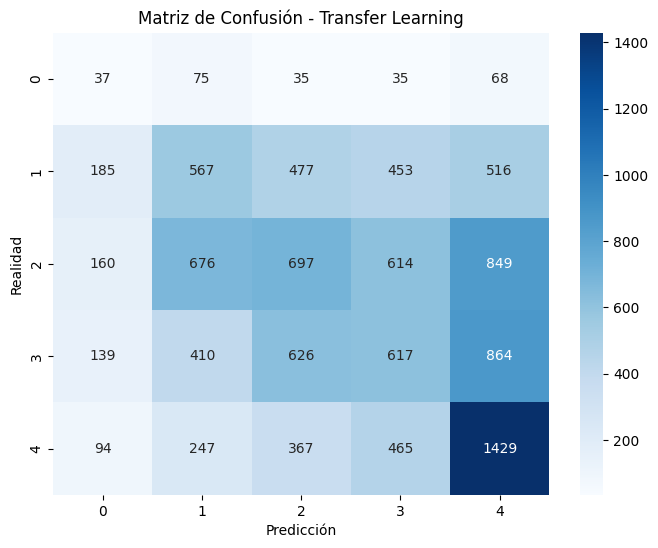

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import os
import seaborn as sns

# Configuración de hiperparámetros
# Aumentamos el batch size para que el gradiente sea más estable
SEED = 42
torch.manual_seed(SEED)
BATCH_SIZE = 50 #16
EPOCHS = 5
LR = 0.0001 # Un learning rate más bajo ayuda en Transfer Learning
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Directorios de datos según la estructura del proyecto
base_datos_drive = r'G:\Mi unidad\Mascotas\datos tratados'
train_dir = os.path.join(base_datos_drive, 'Train')
test_dir = os.path.join(base_datos_drive, 'Test')

# Transformaciones optimizadas
# Reducimos un poco el tamaño a 224x224 para ResNet y eficiencia
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Carga de datos
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform_train)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform_test)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Cálculo de pesos para clases desbalanceadas
targets = train_dataset.targets
weights = compute_class_weight('balanced', classes=np.unique(targets), y=targets)
weights = torch.tensor(weights, dtype=torch.float).to(DEVICE)

# Arquitectura 1: CNN desde Cero (Simple para evitar overfitting)
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.classifier = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        return self.classifier(x)

# Arquitectura 2: Transfer Learning (ResNet50)
def get_transfer_model(num_classes=5):
    # Cargamos pesos pre-entrenados de ImageNet
    model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    # Congelamos las primeras capas para no destruir lo aprendido en ImageNet
    for param in model.parameters():
        param.requires_grad = False
    # Reemplazamos la última capa (fc) por una nueva para nuestras 5 categorías
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_ftrs, 256),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(256, num_classes)
    )
    return model

# Función de pérdida avanzada para problemas ordinales (PetFinder)
class OrdinalLoss(nn.Module):
    def __init__(self, weights):
        super().__init__()
        self.ce = nn.CrossEntropyLoss(weight=weights)
    
    def forward(self, outputs, targets):
        # Cross Entropy estándar
        loss_ce = self.ce(outputs, targets)
        # Penalización por distancia (si predice 4 y era 0, duele más que predecir 1)
        probs = F.softmax(outputs, dim=1)
        idx = torch.arange(outputs.size(1)).to(DEVICE).float()
        pred_mean = torch.sum(probs * idx, dim=1)
        loss_dist = F.mse_loss(pred_mean, targets.float())
        return loss_ce + 0.2 * loss_dist

# Bucle de entrenamiento simplificado
def train_model(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for inputs, labels in tqdm(loader, desc="Entrenando"):
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(loader)

# Evaluación y cálculo de QWK
def evaluate_model(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    qwk = cohen_kappa_score(all_labels, all_preds, weights='quadratic')
    return qwk, all_labels, all_preds

# --- EJECUCIÓN ---
# Probamos el modelo de Transfer Learning que es el que subirá el QWK
model = get_transfer_model().to(DEVICE)
criterion = OrdinalLoss(weights=weights)
optimizer = optim.Adam(model.fc.parameters(), lr=LR)

print("🚀 Iniciando entrenamiento con Transfer Learning...")
for epoch in range(EPOCHS):
    train_loss = train_model(model, train_loader, criterion, optimizer)
    print(f"Época {epoch+1}/{EPOCHS} - Pérdida: {train_loss:.4f}")

qwk_final, labels, preds = evaluate_model(model, test_loader)
print(f"\n✅ QWK: {qwk_final:.4f}")

# Matriz de confusión para diagnóstico
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.title('Matriz de Confusión - Transfer Learning')
plt.show()

🚀 Iniciando entrenamiento con Transfer Learning...


Entrenando: 100%|██████████| 5355/5355 [11:52<00:00,  7.52it/s]


Época 1/10 - Pérdida: 1.7731


Entrenando: 100%|██████████| 5355/5355 [11:33<00:00,  7.72it/s]


Época 2/10 - Pérdida: 1.7444


Entrenando: 100%|██████████| 5355/5355 [11:48<00:00,  7.56it/s]


Época 3/10 - Pérdida: 1.7207


Entrenando: 100%|██████████| 5355/5355 [12:12<00:00,  7.31it/s]


Época 4/10 - Pérdida: 1.7109


Entrenando: 100%|██████████| 5355/5355 [11:43<00:00,  7.61it/s]


Época 5/10 - Pérdida: 1.7003


Entrenando: 100%|██████████| 5355/5355 [11:35<00:00,  7.69it/s]


Época 6/10 - Pérdida: 1.6866


Entrenando: 100%|██████████| 5355/5355 [12:39<00:00,  7.05it/s]


Época 7/10 - Pérdida: 1.6750


Entrenando: 100%|██████████| 5355/5355 [12:00<00:00,  7.43it/s]


Época 8/10 - Pérdida: 1.6641


Entrenando: 100%|██████████| 5355/5355 [11:43<00:00,  7.62it/s]


Época 9/10 - Pérdida: 1.6479


Entrenando: 100%|██████████| 5355/5355 [11:39<00:00,  7.66it/s]


Época 10/10 - Pérdida: 1.6418

✅ QWK: 0.2384


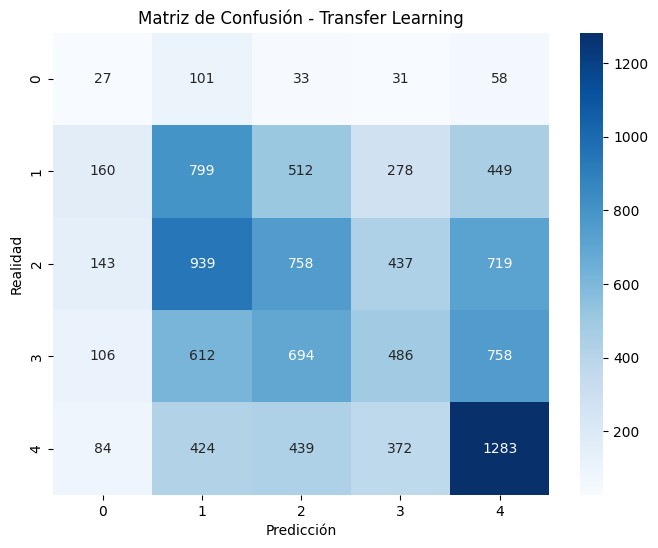

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import os
import seaborn as sns

# Configuración de hiperparámetros
# Aumentamos el batch size para que el gradiente sea más estable
SEED = 42
torch.manual_seed(SEED)
BATCH_SIZE = 8 #16
EPOCHS = 10
LR = 0.0001 # Un learning rate más bajo ayuda en Transfer Learning
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Directorios de datos según la estructura del proyecto
base_datos_drive = r'G:\Mi unidad\Mascotas\datos tratados'
train_dir = os.path.join(base_datos_drive, 'Train')
test_dir = os.path.join(base_datos_drive, 'Test')

# Transformaciones optimizadas
# Reducimos un poco el tamaño a 224x224 para ResNet y eficiencia
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Carga de datos
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform_train)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform_test)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Cálculo de pesos para clases desbalanceadas
targets = train_dataset.targets
weights = compute_class_weight('balanced', classes=np.unique(targets), y=targets)
weights = torch.tensor(weights, dtype=torch.float).to(DEVICE)

# Arquitectura 1: CNN desde Cero (Simple para evitar overfitting)
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.classifier = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        return self.classifier(x)

# Arquitectura 2: Transfer Learning (ResNet50)
def get_transfer_model(num_classes=5):
    # Cargamos pesos pre-entrenados de ImageNet
    model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    # Congelamos las primeras capas para no destruir lo aprendido en ImageNet
    for param in model.parameters():
        param.requires_grad = False
    # Reemplazamos la última capa (fc) por una nueva para nuestras 5 categorías
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_ftrs, 256),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(256, num_classes)
    )
    return model

# Función de pérdida avanzada para problemas ordinales (PetFinder)
class OrdinalLoss(nn.Module):
    def __init__(self, weights):
        super().__init__()
        self.ce = nn.CrossEntropyLoss(weight=weights)
    
    def forward(self, outputs, targets):
        # Cross Entropy estándar
        loss_ce = self.ce(outputs, targets)
        # Penalización por distancia (si predice 4 y era 0, duele más que predecir 1)
        probs = F.softmax(outputs, dim=1)
        idx = torch.arange(outputs.size(1)).to(DEVICE).float()
        pred_mean = torch.sum(probs * idx, dim=1)
        loss_dist = F.mse_loss(pred_mean, targets.float())
        return loss_ce + 0.2 * loss_dist

# Bucle de entrenamiento simplificado
def train_model(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for inputs, labels in tqdm(loader, desc="Entrenando"):
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(loader)

# Evaluación y cálculo de QWK
def evaluate_model(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    qwk = cohen_kappa_score(all_labels, all_preds, weights='quadratic')
    return qwk, all_labels, all_preds

# --- EJECUCIÓN ---
# Probamos el modelo de Transfer Learning que es el que subirá el QWK
model = get_transfer_model().to(DEVICE)
criterion = OrdinalLoss(weights=weights)
optimizer = optim.Adam(model.fc.parameters(), lr=LR)

print("🚀 Iniciando entrenamiento con Transfer Learning...")
for epoch in range(EPOCHS):
    train_loss = train_model(model, train_loader, criterion, optimizer)
    print(f"Época {epoch+1}/{EPOCHS} - Pérdida: {train_loss:.4f}")

qwk_final, labels, preds = evaluate_model(model, test_loader)
print(f"\n✅ QWK: {qwk_final:.4f}")

# Matriz de confusión para diagnóstico
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.title('Matriz de Confusión - Transfer Learning')
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import os
import seaborn as sns

# Aumentamos el batch size para que el gradiente sea más estable
SEED = 42
torch.manual_seed(SEED)
BATCH_SIZE = 16 
EPOCHS = 50
LR = 0.0001 # Un learning rate más bajo ayuda en Transfer Learning
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Directorios de datos según la estructura del proyecto
base_datos_drive = r'G:\Mi unidad\Mascotas\datos tratados'
train_dir = os.path.join(base_datos_drive, 'Train')
test_dir = os.path.join(base_datos_drive, 'Test')

# Transformaciones optimizadas
# Reducimos un poco el tamaño a 224x224 para ResNet y eficiencia
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Carga de datos con persistencia
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform_train)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform_test)

# Importante: num_workers=0 suele evitar el OSError en Google Drive Desktop (Windows)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# Pesos de clase
targets = train_dataset.targets
weights = compute_class_weight('balanced', classes=np.unique(targets), y=targets)
weights = torch.tensor(weights, dtype=torch.float).to(DEVICE)

# Arquitectura 1: CNN desde Cero (Simple para evitar overfitting)
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.classifier = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        return self.classifier(x)

# Arquitectura 2: Transfer Learning (ResNet50)
def get_transfer_model(num_classes=5):
    # Cargamos pesos pre-entrenados de ImageNet
    model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    # Congelamos las primeras capas para no destruir lo aprendido en ImageNet
    for param in model.parameters():
        param.requires_grad = False
    # Reemplazamos la última capa (fc) por una nueva para nuestras 5 categorías
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_ftrs, 256),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(256, num_classes)
    )
    return model

# Función de pérdida avanzada para problemas ordinales (PetFinder)
class OrdinalLoss(nn.Module):
    def __init__(self, weights):
        super().__init__()
        self.ce = nn.CrossEntropyLoss(weight=weights)
    
    def forward(self, outputs, targets):
        # Cross Entropy estándar
        loss_ce = self.ce(outputs, targets)
        # Penalización por distancia (si predice 4 y era 0, duele más que predecir 1)
        probs = F.softmax(outputs, dim=1)
        idx = torch.arange(outputs.size(1)).to(DEVICE).float()
        pred_mean = torch.sum(probs * idx, dim=1)
        loss_dist = F.mse_loss(pred_mean, targets.float())
        return loss_ce + 0.2 * loss_dist

# Bucle de entrenamiento simplificado
def train_model(model, loader, criterion, optimizer, epoch):
    model.train()
    running_loss = 0.0
    for inputs, labels in tqdm(loader, desc=f"Época {epoch+1}/{EPOCHS}"):
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    # Guardamos checkpoint al final de cada época
    torch.save(model.state_dict(), 'checkpoint_petfinder.pth')
    return running_loss / len(loader)

# Evaluación y cálculo de QWK
def evaluate_model(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    qwk = cohen_kappa_score(all_labels, all_preds, weights='quadratic')
    return qwk, all_labels, all_preds

# --- EJECUCIÓN ---
# Probamos el modelo de Transfer Learning que es el que subirá el QWK
model = get_transfer_model().to(DEVICE)
criterion = OrdinalLoss(weights=weights)
optimizer = optim.Adam(model.fc.parameters(), lr=LR)

print("🚀 Iniciando entrenamiento con Transfer Learning...")
for epoch in range(EPOCHS):
    train_loss = train_model(model, train_loader, criterion, optimizer)
    print(f"Época {epoch+1}/{EPOCHS} - Pérdida: {train_loss:.4f}")

qwk_final, labels, preds = evaluate_model(model, test_loader)
print(f"\n✅ QWK: {qwk_final:.4f}")

# Matriz de confusión para diagnóstico
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.title('Matriz de Confusión - Transfer Learning')
plt.show()

🚀 Iniciando entrenamiento con Transfer Learning...


Entrenando: 100%|██████████| 2678/2678 [11:16<00:00,  3.96it/s]


Época 1/50 - Pérdida: 1.7913


Entrenando: 100%|██████████| 2678/2678 [11:01<00:00,  4.05it/s]


Época 2/50 - Pérdida: 1.7518


Entrenando: 100%|██████████| 2678/2678 [11:05<00:00,  4.03it/s]


Época 3/50 - Pérdida: 1.7259


Entrenando: 100%|██████████| 2678/2678 [11:01<00:00,  4.05it/s]


Época 4/50 - Pérdida: 1.7102


Entrenando: 100%|██████████| 2678/2678 [10:55<00:00,  4.09it/s]


Época 5/50 - Pérdida: 1.6912


Entrenando: 100%|██████████| 2678/2678 [11:04<00:00,  4.03it/s]


Época 6/50 - Pérdida: 1.6751


Entrenando: 100%|██████████| 2678/2678 [10:55<00:00,  4.08it/s]


Época 7/50 - Pérdida: 1.6576


Entrenando: 100%|██████████| 2678/2678 [10:59<00:00,  4.06it/s]


Época 8/50 - Pérdida: 1.6412


Entrenando: 100%|██████████| 2678/2678 [11:32<00:00,  3.87it/s]


Época 9/50 - Pérdida: 1.6160


Entrenando: 100%|██████████| 2678/2678 [11:17<00:00,  3.95it/s]


Época 10/50 - Pérdida: 1.6031


Entrenando: 100%|██████████| 2678/2678 [10:59<00:00,  4.06it/s]


Época 11/50 - Pérdida: 1.5915


Entrenando: 100%|██████████| 2678/2678 [10:55<00:00,  4.08it/s]


Época 12/50 - Pérdida: 1.5670


Entrenando: 100%|██████████| 2678/2678 [10:57<00:00,  4.07it/s]


Época 13/50 - Pérdida: 1.5519


Entrenando: 100%|██████████| 2678/2678 [10:56<00:00,  4.08it/s]


Época 14/50 - Pérdida: 1.5401


Entrenando: 100%|██████████| 2678/2678 [10:59<00:00,  4.06it/s]


Época 15/50 - Pérdida: 1.5307


Entrenando: 100%|██████████| 2678/2678 [11:01<00:00,  4.05it/s]


Época 16/50 - Pérdida: 1.5051


Entrenando: 100%|██████████| 2678/2678 [10:56<00:00,  4.08it/s]


Época 17/50 - Pérdida: 1.4920


Entrenando: 100%|██████████| 2678/2678 [10:58<00:00,  4.06it/s]


Época 18/50 - Pérdida: 1.4734


Entrenando: 100%|██████████| 2678/2678 [10:57<00:00,  4.07it/s]


Época 19/50 - Pérdida: 1.4683


Entrenando: 100%|██████████| 2678/2678 [10:58<00:00,  4.07it/s]


Época 20/50 - Pérdida: 1.4510


Entrenando: 100%|██████████| 2678/2678 [10:56<00:00,  4.08it/s]


Época 21/50 - Pérdida: 1.4384


Entrenando: 100%|██████████| 2678/2678 [11:02<00:00,  4.04it/s]


Época 22/50 - Pérdida: 1.4190


Entrenando: 100%|██████████| 2678/2678 [10:57<00:00,  4.07it/s]


Época 23/50 - Pérdida: 1.4122


Entrenando: 100%|██████████| 2678/2678 [10:54<00:00,  4.09it/s]


Época 24/50 - Pérdida: 1.3929


Entrenando: 100%|██████████| 2678/2678 [10:55<00:00,  4.08it/s]


Época 25/50 - Pérdida: 1.3799


Entrenando: 100%|██████████| 2678/2678 [10:58<00:00,  4.07it/s]


Época 26/50 - Pérdida: 1.3772


Entrenando: 100%|██████████| 2678/2678 [11:00<00:00,  4.05it/s]


Época 27/50 - Pérdida: 1.3608


Entrenando: 100%|██████████| 2678/2678 [10:58<00:00,  4.07it/s]


Época 28/50 - Pérdida: 1.3461


Entrenando: 100%|██████████| 2678/2678 [10:55<00:00,  4.08it/s]


Época 29/50 - Pérdida: 1.3416


Entrenando: 100%|██████████| 2678/2678 [10:53<00:00,  4.10it/s]


Época 30/50 - Pérdida: 1.3298


Entrenando: 100%|██████████| 2678/2678 [10:57<00:00,  4.07it/s]


Época 31/50 - Pérdida: 1.3109


Entrenando: 100%|██████████| 2678/2678 [11:00<00:00,  4.05it/s]


Época 32/50 - Pérdida: 1.3031


Entrenando: 100%|██████████| 2678/2678 [11:03<00:00,  4.04it/s]


Época 33/50 - Pérdida: 1.2916


Entrenando: 100%|██████████| 2678/2678 [10:57<00:00,  4.08it/s]


Época 34/50 - Pérdida: 1.2825


Entrenando: 100%|██████████| 2678/2678 [10:56<00:00,  4.08it/s]


Época 35/50 - Pérdida: 1.2780


Entrenando: 100%|██████████| 2678/2678 [10:57<00:00,  4.07it/s]


Época 36/50 - Pérdida: 1.2701


Entrenando: 100%|██████████| 2678/2678 [11:00<00:00,  4.05it/s]


Época 37/50 - Pérdida: 1.2543


Entrenando: 100%|██████████| 2678/2678 [11:11<00:00,  3.99it/s]


Época 38/50 - Pérdida: 1.2498


Entrenando: 100%|██████████| 2678/2678 [10:56<00:00,  4.08it/s]


Época 39/50 - Pérdida: 1.2390


Entrenando: 100%|██████████| 2678/2678 [11:07<00:00,  4.01it/s]


Época 40/50 - Pérdida: 1.2350


Entrenando: 100%|██████████| 2678/2678 [10:59<00:00,  4.06it/s]


Época 41/50 - Pérdida: 1.2319


Entrenando: 100%|██████████| 2678/2678 [11:02<00:00,  4.04it/s]


Época 42/50 - Pérdida: 1.2125


Entrenando: 100%|██████████| 2678/2678 [10:54<00:00,  4.09it/s]


Época 43/50 - Pérdida: 1.2147


Entrenando: 100%|██████████| 2678/2678 [10:56<00:00,  4.08it/s]


Época 44/50 - Pérdida: 1.2024


Entrenando: 100%|██████████| 2678/2678 [10:53<00:00,  4.10it/s]


Época 45/50 - Pérdida: 1.2028


Entrenando: 100%|██████████| 2678/2678 [10:52<00:00,  4.10it/s]


Época 46/50 - Pérdida: 1.1928


Entrenando: 100%|██████████| 2678/2678 [10:54<00:00,  4.09it/s]


Época 47/50 - Pérdida: 1.1885


Entrenando: 100%|██████████| 2678/2678 [10:52<00:00,  4.11it/s]


Época 48/50 - Pérdida: 1.1780


Entrenando: 100%|██████████| 2678/2678 [10:55<00:00,  4.09it/s]


Época 49/50 - Pérdida: 1.1661


Entrenando:  76%|███████▌  | 2025/2678 [08:13<02:39,  4.11it/s]


OSError: [Errno 22] Invalid argument

Intentando evaluar con el modelo actual en memoria...
------------------------------
✅ QWK (Métrica Ordinal): 0.2457
✅ Accuracy Global: 0.3275 (32.75%)
------------------------------


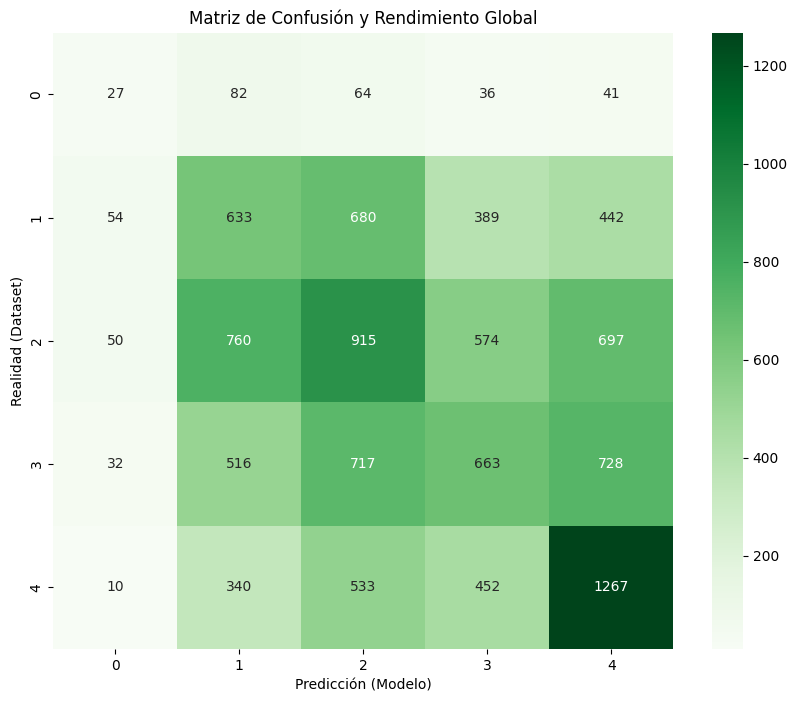

In [ ]:
from sklearn.metrics import accuracy_score

try:
    print("Intentando evaluar con el modelo actual en memoria...")
    
    # Obtenemos las etiquetas reales y las predicciones
    qwk_final, labels, preds = evaluate_model(model, test_loader)
    
    # Calculamos el Accuracy Global
    acc_global = accuracy_score(labels, preds)
    
    # Mostramos los resultados principales
    print("-" * 30)
    print(f"✅ QWK (Métrica Ordinal): {qwk_final:.4f}")
    print(f"✅ Accuracy Global: {acc_global:.4f} ({acc_global*100:.2f}%)")
    print("-" * 30)

    # Matriz de Confusión para el análisis visual
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        cmap='Greens', 
        xticklabels=train_dataset.classes, 
        yticklabels=train_dataset.classes
    )
    
    plt.xlabel('Predicción (Modelo)')
    plt.ylabel('Realidad (Dataset)')
    plt.title('Matriz de Confusión y Rendimiento Global')
    plt.show()

except NameError:
    print("❌ Error: El modelo o los datos no están cargados en la memoria actual.")
    print("Asegúrate de haber ejecutado las celdas de definición de funciones y carga de datos.")

# Redes neuronales para multiclase desde 0


🚀 Iniciando entrenamiento en cuda...


Época 1/5: 100%|██████████| 1339/1339 [13:13<00:00,  1.69it/s, loss=1.3951]


📊 Val Acc: 0.2869 | Val QWK: 0.0310


Época 2/5: 100%|██████████| 1339/1339 [13:40<00:00,  1.63it/s, loss=1.3454]


📊 Val Acc: 0.2845 | Val QWK: 0.0349


Época 3/5: 100%|██████████| 1339/1339 [13:25<00:00,  1.66it/s, loss=1.4994]


📊 Val Acc: 0.2852 | Val QWK: 0.0737


Época 4/5: 100%|██████████| 1339/1339 [07:41<00:00,  2.90it/s, loss=1.3962]


📊 Val Acc: 0.2845 | Val QWK: 0.0511


Época 5/5: 100%|██████████| 1339/1339 [07:19<00:00,  3.05it/s, loss=1.3798]


📊 Val Acc: 0.2834 | Val QWK: 0.0512


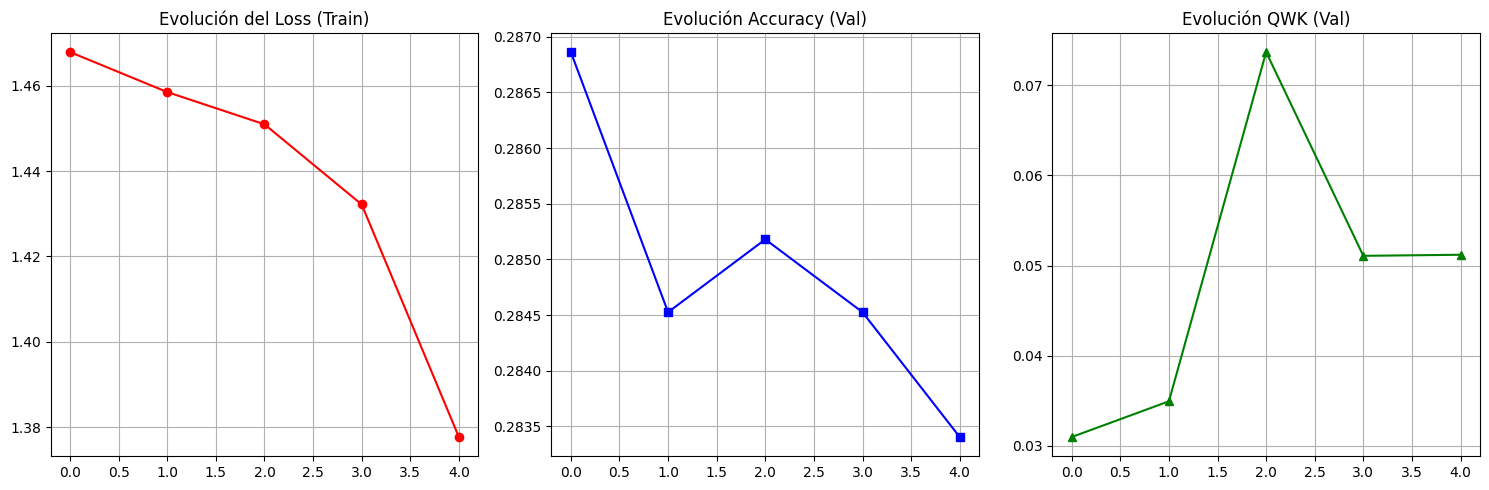

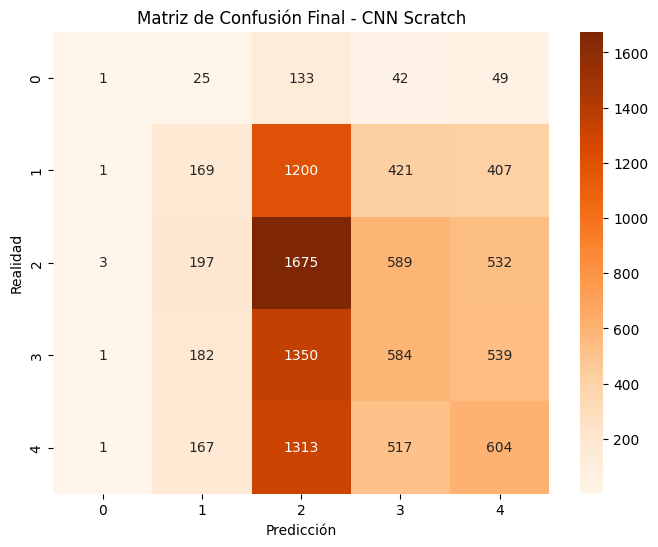


✅ Proceso completado. QWK Final: 0.0512


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
import time
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, cohen_kappa_score, confusion_matrix

# --- 1. CONFIGURACIÓN DE DATOS 
base_datos_drive = r'G:\Mi unidad\Mascotas\datos tratados'
train_dir = os.path.join(base_datos_drive, 'Train')
test_dir = os.path.join(base_datos_drive, 'Test')

transform_pet = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset_pet = datasets.ImageFolder(train_dir, transform=transform_pet)
val_dataset_pet = datasets.ImageFolder(test_dir, transform=transform_pet)

train_loader_pet = DataLoader(train_dataset_pet, batch_size=32, shuffle=True)
val_loader_pet = DataLoader(val_dataset_pet, batch_size=32, shuffle=False)

# --- 2. DEFINICIÓN DE LA ARQUITECTURA (Scratch) ---
class PetNetScratch(nn.Module):
    def __init__(self, num_classes=5):
        super(PetNetScratch, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2), # 64x64
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2), # 32x32
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2) # 16x16
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.classifier(self.features(x))

# --- 3. ENTRENAMIENTO Y VALIDACIÓN ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_scratch = PetNetScratch(num_classes=len(train_dataset_pet.classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_scratch.parameters(), lr=0.001)

epochs = 5
history = {'train_loss': [], 'val_acc': [], 'val_qwk': []}

print(f"🚀 Iniciando entrenamiento en {device}...")
for epoch in range(epochs):
    # FASE DE ENTRENAMIENTO
    model_scratch.train()
    running_loss = 0.0
    pbar = tqdm(train_loader_pet, desc=f"Época {epoch+1}/{epochs}")
    
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_scratch(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        pbar.set_postfix({'loss': f"{loss.item():.4f}"})
    
    history['train_loss'].append(running_loss / len(train_loader_pet))

    # FASE DE VALIDACIÓN (Por época para el gráfico)
    model_scratch.eval()
    epoch_preds, epoch_labels = [], []
    with torch.no_grad():
        for inputs, labels in val_loader_pet:
            outputs = model_scratch(inputs.to(device))
            _, preds = torch.max(outputs, 1)
            epoch_preds.extend(preds.cpu().numpy())
            epoch_labels.extend(labels.numpy())
    
    acc_epoch = accuracy_score(epoch_labels, epoch_preds)
    qwk_epoch = cohen_kappa_score(epoch_labels, epoch_preds, weights='quadratic')
    history['val_acc'].append(acc_epoch)
    history['val_qwk'].append(qwk_epoch)
    
    print(f"📊 Val Acc: {acc_epoch:.4f} | Val QWK: {qwk_epoch:.4f}")

# --- 4. VISUALIZACIÓN DE RESULTADOS ---
# Gráfica de Loss, Accuracy y QWK
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history['train_loss'], label='Loss', color='red', marker='o')
plt.title('Evolución del Loss (Train)')
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(history['val_acc'], label='Accuracy', color='blue', marker='s')
plt.title('Evolución Accuracy (Val)')
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(history['val_qwk'], label='QWK', color='green', marker='^')
plt.title('Evolución QWK (Val)')
plt.grid(True)

plt.tight_layout()
plt.show()

# Matriz de Confusión Final
cm = confusion_matrix(epoch_labels, epoch_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', 
            xticklabels=train_dataset_pet.classes, 
            yticklabels=train_dataset_pet.classes)
plt.title('Matriz de Confusión Final - CNN Scratch')
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.show()

print(f"\n✅ Proceso completado. QWK Final: {history['val_qwk'][-1]:.4f}")

🚀 Iniciando entrenamiento en cuda con batch size de 4...


Época 1/20: 100%|██████████| 10710/10710 [08:23<00:00, 21.27it/s, loss=1.4553]


📊 Val Acc: 0.2482 | Val QWK: 0.0000


Época 2/20: 100%|██████████| 10710/10710 [09:09<00:00, 19.49it/s, loss=1.4455]


📊 Val Acc: 0.2799 | Val QWK: 0.0000


Época 3/20: 100%|██████████| 10710/10710 [08:54<00:00, 20.06it/s, loss=1.4582]


📊 Val Acc: 0.2799 | Val QWK: 0.0000


Época 4/20: 100%|██████████| 10710/10710 [08:51<00:00, 20.15it/s, loss=1.4601]


📊 Val Acc: 0.2799 | Val QWK: 0.0000


Época 5/20: 100%|██████████| 10710/10710 [08:54<00:00, 20.04it/s, loss=1.4208]


📊 Val Acc: 0.2799 | Val QWK: 0.0000


Época 6/20: 100%|██████████| 10710/10710 [08:52<00:00, 20.11it/s, loss=1.3209]


📊 Val Acc: 0.2799 | Val QWK: 0.0000


Época 7/20: 100%|██████████| 10710/10710 [08:54<00:00, 20.03it/s, loss=1.4568]


📊 Val Acc: 0.2799 | Val QWK: 0.0000


Época 8/20: 100%|██████████| 10710/10710 [08:51<00:00, 20.15it/s, loss=1.4032]


📊 Val Acc: 0.2799 | Val QWK: 0.0000


Época 9/20: 100%|██████████| 10710/10710 [09:40<00:00, 18.45it/s, loss=1.3443]


📊 Val Acc: 0.2799 | Val QWK: 0.0000


Época 10/20: 100%|██████████| 10710/10710 [09:45<00:00, 18.30it/s, loss=1.4677]


📊 Val Acc: 0.2799 | Val QWK: 0.0000


Época 11/20: 100%|██████████| 10710/10710 [09:48<00:00, 18.19it/s, loss=1.4181]


📊 Val Acc: 0.2799 | Val QWK: 0.0000


Época 12/20: 100%|██████████| 10710/10710 [09:49<00:00, 18.15it/s, loss=1.5462]


📊 Val Acc: 0.2799 | Val QWK: 0.0000


Época 13/20: 100%|██████████| 10710/10710 [09:42<00:00, 18.40it/s, loss=1.4238]


📊 Val Acc: 0.2799 | Val QWK: 0.0000


Época 14/20: 100%|██████████| 10710/10710 [09:51<00:00, 18.10it/s, loss=1.9560]


📊 Val Acc: 0.2799 | Val QWK: 0.0000


Época 15/20: 100%|██████████| 10710/10710 [09:42<00:00, 18.38it/s, loss=1.3703]


📊 Val Acc: 0.2799 | Val QWK: 0.0000


Época 16/20: 100%|██████████| 10710/10710 [09:49<00:00, 18.16it/s, loss=1.5062]


📊 Val Acc: 0.2799 | Val QWK: 0.0000


Época 17/20: 100%|██████████| 10710/10710 [09:38<00:00, 18.52it/s, loss=1.5084]


📊 Val Acc: 0.2799 | Val QWK: 0.0000


Época 18/20: 100%|██████████| 10710/10710 [09:45<00:00, 18.30it/s, loss=1.3431]


📊 Val Acc: 0.2799 | Val QWK: 0.0000


Época 19/20: 100%|██████████| 10710/10710 [09:36<00:00, 18.58it/s, loss=1.4446]


📊 Val Acc: 0.2799 | Val QWK: 0.0000


Época 20/20: 100%|██████████| 10710/10710 [09:33<00:00, 18.69it/s, loss=1.5023]


📊 Val Acc: 0.2799 | Val QWK: 0.0000

⏱️ Tiempo total de entrenamiento: 13472.40s


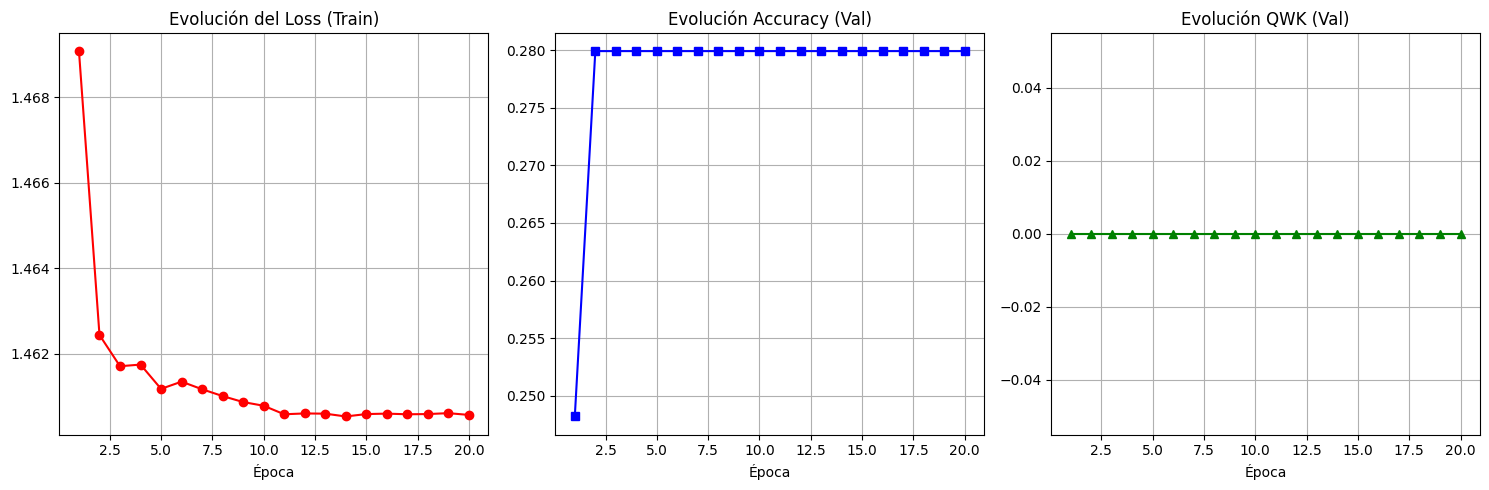

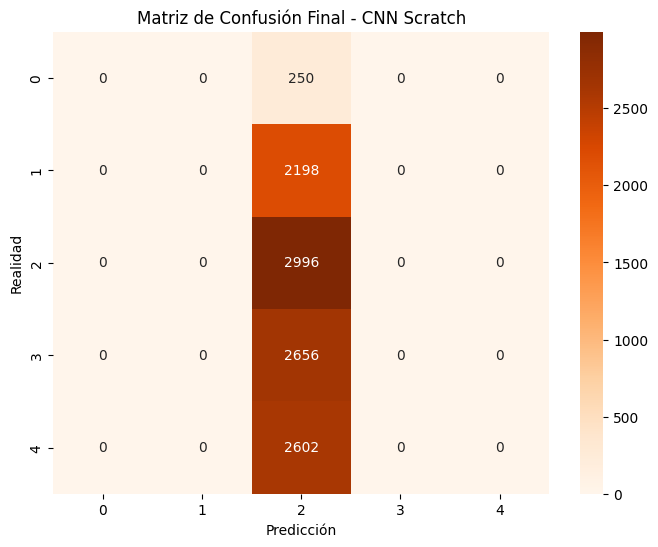


✅ Proceso completado. QWK Final: 0.0000


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
import time
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, cohen_kappa_score, confusion_matrix

# --- 1. CONFIGURACIÓN DE DATOS (128x128 y Batch 4) ---
base_datos_drive = r'G:\Mi unidad\Mascotas\datos tratados'
train_dir = os.path.join(base_datos_drive, 'Train')
test_dir = os.path.join(base_datos_drive, 'Test')

transform_pet = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset_pet = datasets.ImageFolder(train_dir, transform=transform_pet)
val_dataset_pet = datasets.ImageFolder(test_dir, transform=transform_pet)

# Actualización de batch_size a 4
train_loader_pet = DataLoader(train_dataset_pet, batch_size=4, shuffle=True)
val_loader_pet = DataLoader(val_dataset_pet, batch_size=4, shuffle=False)

# --- 2. DEFINICIÓN DE LA ARQUITECTURA (Scratch) ---
class PetNetScratch(nn.Module):
    def __init__(self, num_classes=5):
        super(PetNetScratch, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2), # 64x64
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2), # 32x32
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2) # 16x16
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.classifier(self.features(x))

# --- 3. ENTRENAMIENTO Y VALIDACIÓN  ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_scratch = PetNetScratch(num_classes=len(train_dataset_pet.classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_scratch.parameters(), lr=0.001)

epochs = 20 # Actualizado a 20 épocas
history = {'train_loss': [], 'val_acc': [], 'val_qwk': []}

print(f"🚀 Iniciando entrenamiento en {device} con batch size de 4...")
start_total_time = time.time()

for epoch in range(epochs):
    # FASE DE ENTRENAMIENTO
    model_scratch.train()
    running_loss = 0.0
    pbar = tqdm(train_loader_pet, desc=f"Época {epoch+1}/{epochs}")
    
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_scratch(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        pbar.set_postfix({'loss': f"{loss.item():.4f}"})
    
    history['train_loss'].append(running_loss / len(train_loader_pet))

    # FASE DE VALIDACIÓN
    model_scratch.eval()
    epoch_preds, epoch_labels = [], []
    with torch.no_grad():
        for inputs, labels in val_loader_pet:
            outputs = model_scratch(inputs.to(device))
            _, preds = torch.max(outputs, 1)
            epoch_preds.extend(preds.cpu().numpy())
            epoch_labels.extend(labels.numpy())
    
    acc_epoch = accuracy_score(epoch_labels, epoch_preds)
    qwk_epoch = cohen_kappa_score(epoch_labels, epoch_preds, weights='quadratic')
    history['val_acc'].append(acc_epoch)
    history['val_qwk'].append(qwk_epoch)
    
    print(f"📊 Val Acc: {acc_epoch:.4f} | Val QWK: {qwk_epoch:.4f}")

print(f"\n⏱️ Tiempo total de entrenamiento: {time.time() - start_total_time:.2f}s")

# --- 4. VISUALIZACIÓN DE RESULTADOS ---
plt.figure(figsize=(15, 5))

# Gráfica de Loss
plt.subplot(1, 3, 1)
plt.plot(range(1, epochs + 1), history['train_loss'], label='Loss', color='red', marker='o')
plt.title('Evolución del Loss (Train)')
plt.xlabel('Época')
plt.grid(True)

# Gráfica de Accuracy
plt.subplot(1, 3, 2)
plt.plot(range(1, epochs + 1), history['val_acc'], label='Accuracy', color='blue', marker='s')
plt.title('Evolución Accuracy (Val)')
plt.xlabel('Época')
plt.grid(True)

# Gráfica de QWK
plt.subplot(1, 3, 3)
plt.plot(range(1, epochs + 1), history['val_qwk'], label='QWK', color='green', marker='^')
plt.title('Evolución QWK (Val)')
plt.xlabel('Época')
plt.grid(True)

plt.tight_layout()
plt.show()

# Matriz de Confusión Final
cm = confusion_matrix(epoch_labels, epoch_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', 
            xticklabels=train_dataset_pet.classes, 
            yticklabels=train_dataset_pet.classes)
plt.title('Matriz de Confusión Final - CNN Scratch')
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.show()

print(f"\n✅ Proceso completado. QWK Final: {history['val_qwk'][-1]:.4f}")

🚀 Iniciando entrenamiento (20 épocas)... Objetivo QWK > 0.1


Evaluación Final: 100%|██████████| 2676/2676 [02:20<00:00, 19.03it/s]


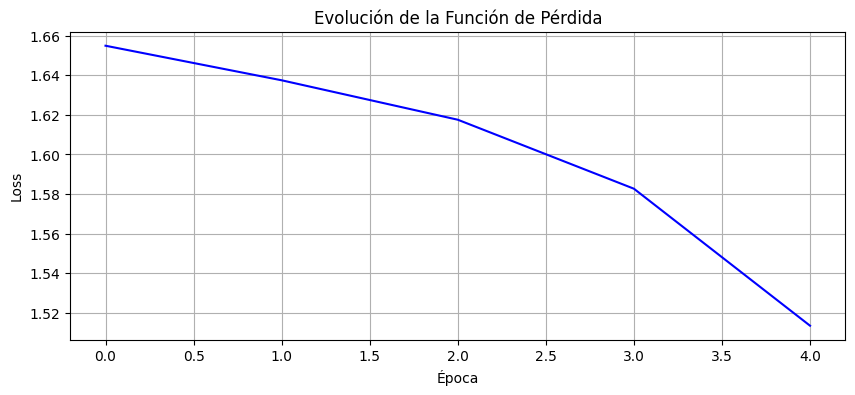

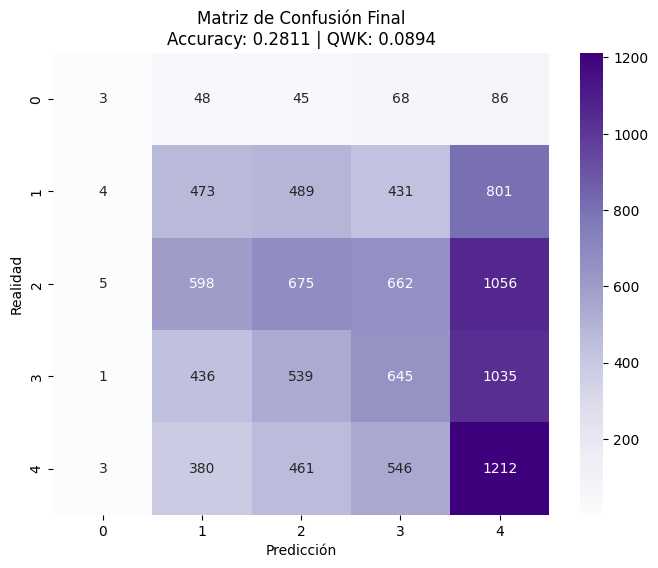


✅ RESULTADOS FINALES:
Accuracy: 0.2811
QWK:      0.0894


In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os
import time
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, cohen_kappa_score, confusion_matrix

# --- 1. PREPARACIÓN DE DATOS (Batch 4, 128x128) ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_datos_drive = r'G:\Mi unidad\Mascotas\datos tratados'
train_dir = os.path.join(base_datos_drive, 'Train')
test_dir = os.path.join(base_datos_drive, 'Test')

transform_base = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(train_dir, transform=transform_base)
val_dataset = datasets.ImageFolder(test_dir, transform=transform_base)

train_loader_pet = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader_pet = DataLoader(val_dataset, batch_size=4, shuffle=False)

# --- 2. MODELO DESDE CERO ---
class PetNetScratch(nn.Module):
    def __init__(self, num_classes=5):
        super(PetNetScratch, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 256), nn.ReLU(), nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.classifier(self.features(x))

# --- 3. LOSS AVANZADA: ORDINAL + MAXIMIZACIÓN DE ENTROPÍA ---
class EnhancedOrdinalLoss(nn.Module):
    def __init__(self, weights, entropy_coef=0.1):
        super().__init__()
        self.ce = nn.CrossEntropyLoss(weight=weights)
        self.entropy_coef = entropy_coef
    
    def forward(self, outputs, targets):
        # A. Cross Entropy (Acierto)
        loss_ce = self.ce(outputs, targets)
        
        # B. Distancia Ordinal (MSE sobre esperanza)
        probs = F.softmax(outputs, dim=1)
        idx = torch.arange(outputs.size(1)).to(device).float()
        pred_mean = torch.sum(probs * idx, dim=1)
        loss_dist = F.mse_loss(pred_mean, targets.float())
        
        # C. Maximización de Entropía (Penalizamos entropía baja para evitar predicción única)
        # La entropía es -sum(p * log(p)). Para maximizarla, restamos este término del Loss.
        entropy = -torch.sum(probs * torch.log(probs + 1e-9), dim=1).mean()
        
        # Total = Clasificación + Distancia - Entropía (para maximizarla)
        return loss_ce + 0.2 * loss_dist - self.entropy_coef * entropy

# --- 4. ENTRENAMIENTO (20 ÉPOCAS, SIN MÉTRICAS POR ÉPOCA) ---
targets_tensor = torch.tensor(train_dataset.targets)
class_count = torch.tensor([(targets_tensor == t).sum() for t in torch.unique(targets_tensor)])
weights = (1. / class_count.float()).to(device)

model = PetNetScratch(num_classes=5).to(device)
criterion = EnhancedOrdinalLoss(weights=weights)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

epochs = 5
history_loss = []

print(f"🚀 Iniciando entrenamiento (20 épocas)... Objetivo QWK > 0.1")
for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    for inputs, labels in tqdm(train_loader_pet, desc=f"Época {epoch+1}/{epochs}"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    history_loss.append(epoch_loss / len(train_loader_pet))

# --- 5. EVALUACIÓN FINAL Y MÉTRICAS ---
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in tqdm(val_loader_pet, desc="Evaluación Final"):
        outputs = model(inputs.to(device))
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Cálculo de métricas finales
final_acc = accuracy_score(all_labels, all_preds)
final_qwk = cohen_kappa_score(all_labels, all_preds, weights='quadratic')

# --- VISUALIZACIÓN ---
# 1. Evolución del Loss
plt.figure(figsize=(10, 4))
plt.plot(history_loss, color='blue', label='Train Loss (Ordinal+Entropy)')
plt.title('Evolución de la Función de Pérdida')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# 2. Matriz de Confusión
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(all_labels, all_preds), annot=True, fmt='d', cmap='Purples',
            xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.title(f'Matriz de Confusión Final\nAccuracy: {final_acc:.4f} | QWK: {final_qwk:.4f}')
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.show()

print(f"\n✅ RESULTADOS FINALES:")
print(f"Accuracy: {final_acc:.4f}")
print(f"QWK:      {final_qwk:.4f}")

🚀 Iniciando entrenamiento con Batch Size = 8...


Evaluación Final: 100%|██████████| 1338/1338 [02:07<00:00, 10.51it/s]


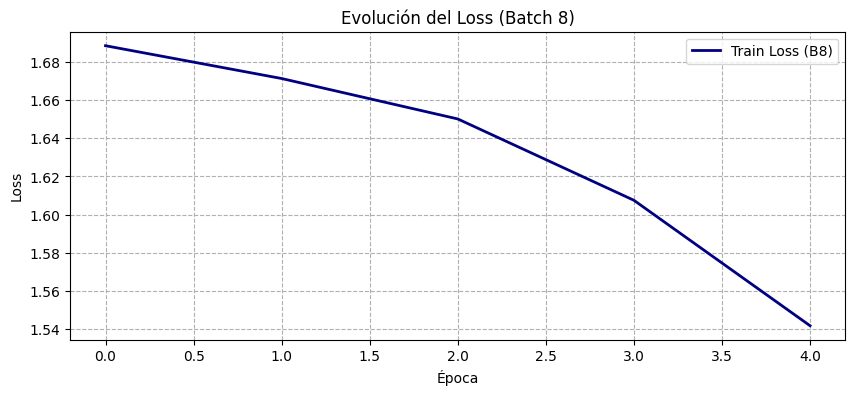

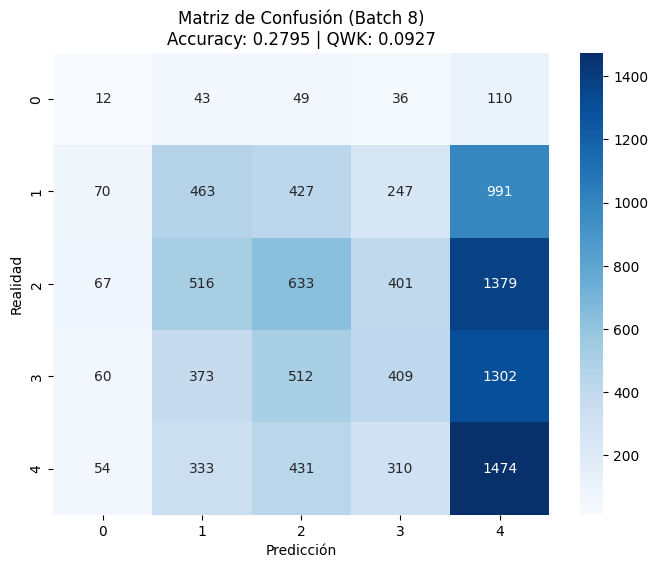


📊 RESULTADOS FINALES (Batch 8):
Accuracy: 0.2795
QWK:      0.0927


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os
import time
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, cohen_kappa_score, confusion_matrix

# --- 1. CONFIGURACIÓN DE DATOS (Batch 8, 128x128) ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_datos_drive = r'G:\Mi unidad\Mascotas\datos tratados'
train_dir = os.path.join(base_datos_drive, 'Train')
test_dir = os.path.join(base_datos_drive, 'Test')

transform_base = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(train_dir, transform=transform_base)
val_dataset = datasets.ImageFolder(test_dir, transform=transform_base)

# Cambio solicitado: batch_size=8
batch_size = 8
train_loader_pet = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader_pet = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# --- 2. MODELO DESDE CERO (Arquitectura para 128x128) ---
class PetNetScratch(nn.Module):
    def __init__(self, num_classes=5):
        super(PetNetScratch, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 256), nn.ReLU(), nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.classifier(self.features(x))

# --- 3. LOSS AVANZADA: ORDINAL + MAXIMIZACIÓN DE ENTROPÍA ---
class EnhancedOrdinalLoss(nn.Module):
    def __init__(self, weights, entropy_coef=0.1):
        super().__init__()
        self.ce = nn.CrossEntropyLoss(weight=weights)
        self.entropy_coef = entropy_coef
    
    def forward(self, outputs, targets):
        # A. Cross Entropy
        loss_ce = self.ce(outputs, targets)
        
        # B. Distancia Ordinal (MSE sobre esperanza)
        probs = F.softmax(outputs, dim=1)
        idx = torch.arange(outputs.size(1)).to(device).float()
        pred_mean = torch.sum(probs * idx, dim=1)
        loss_dist = F.mse_loss(pred_mean, targets.float())
        
        # C. Maximización de Entropía (evita colapso en una sola clase)
        entropy = -torch.sum(probs * torch.log(probs + 1e-9), dim=1).mean()
        
        return loss_ce + 0.2 * loss_dist - self.entropy_coef * entropy

# --- 4. ENTRENAMIENTO (20 ÉPOCAS) ---
targets_tensor = torch.tensor(train_dataset.targets)
class_count = torch.tensor([(targets_tensor == t).sum() for t in torch.unique(targets_tensor)])
weights = (1. / class_count.float()).to(device)

model = PetNetScratch(num_classes=5).to(device)
criterion = EnhancedOrdinalLoss(weights=weights)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

epochs = 5
history_loss = []

print(f"🚀 Iniciando entrenamiento con Batch Size = {batch_size}...")
for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    for inputs, labels in tqdm(train_loader_pet, desc=f"Época {epoch+1}/{epochs}"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    history_loss.append(epoch_loss / len(train_loader_pet))

# --- 5. EVALUACIÓN FINAL ---
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in tqdm(val_loader_pet, desc="Evaluación Final"):
        outputs = model(inputs.to(device))
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

final_acc = accuracy_score(all_labels, all_preds)
final_qwk = cohen_kappa_score(all_labels, all_preds, weights='quadratic')

# --- VISUALIZACIÓN ---
# Evolución del Loss
plt.figure(figsize=(10, 4))
plt.plot(history_loss, color='navy', linewidth=2, label='Train Loss (B8)')
plt.title(f'Evolución del Loss (Batch {batch_size})')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.grid(True, linestyle='--')
plt.legend()
plt.show()

# Matriz de Confusión
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(all_labels, all_preds), annot=True, fmt='d', cmap='Blues',
            xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.title(f'Matriz de Confusión (Batch {batch_size})\nAccuracy: {final_acc:.4f} | QWK: {final_qwk:.4f}')
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.show()

print(f"\n📊 RESULTADOS FINALES (Batch {batch_size}):")
print(f"Accuracy: {final_acc:.4f}")
print(f"QWK:      {final_qwk:.4f}")

🚀 Iniciando entrenamiento con Batch Size = 16...


Evaluación Final: 100%|██████████| 669/669 [02:19<00:00,  4.78it/s]


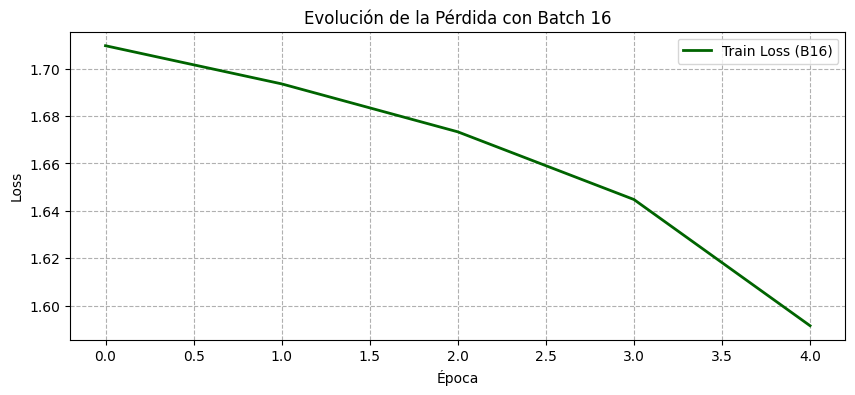

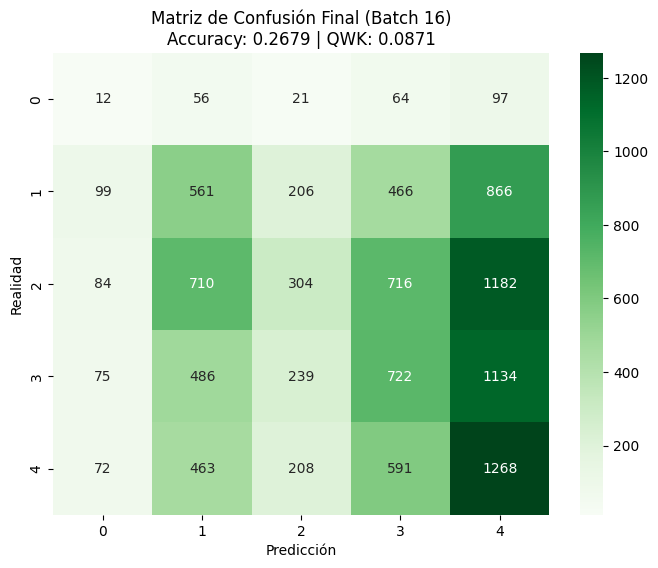


📊 RESULTADOS FINALES (Batch 16):
Accuracy: 0.2679
QWK:      0.0871


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os
import time
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, cohen_kappa_score, confusion_matrix

# --- 1. CONFIGURACIÓN DE DATOS (Batch 16, 128x128) ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_datos_drive = r'G:\Mi unidad\Mascotas\datos tratados'
train_dir = os.path.join(base_datos_drive, 'Train')
test_dir = os.path.join(base_datos_drive, 'Test')

transform_base = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(train_dir, transform=transform_base)
val_dataset = datasets.ImageFolder(test_dir, transform=transform_base)

# Cambio solicitado: batch_size=16
batch_size = 16
train_loader_pet = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader_pet = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# --- 2. MODELO DESDE CERO ---
class PetNetScratch(nn.Module):
    def __init__(self, num_classes=5):
        super(PetNetScratch, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 256), nn.ReLU(), nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.classifier(self.features(x))

# --- 3. LOSS AVANZADA: ORDINAL + MAXIMIZACIÓN DE ENTROPÍA ---
class EnhancedOrdinalLoss(nn.Module):
    def __init__(self, weights, entropy_coef=0.1):
        super().__init__()
        self.ce = nn.CrossEntropyLoss(weight=weights)
        self.entropy_coef = entropy_coef
    
    def forward(self, outputs, targets):
        # A. Cross Entropy (Acierto)
        loss_ce = self.ce(outputs, targets)
        
        # B. Distancia Ordinal (MSE sobre esperanza)
        probs = F.softmax(outputs, dim=1)
        idx = torch.arange(outputs.size(1)).to(device).float()
        pred_mean = torch.sum(probs * idx, dim=1)
        loss_dist = F.mse_loss(pred_mean, targets.float())
        
        # C. Maximización de Entropía (evita que el modelo prediga siempre lo mismo)
        entropy = -torch.sum(probs * torch.log(probs + 1e-9), dim=1).mean()
        
        # Restamos la entropía para maximizarla (penalizamos la falta de diversidad)
        return loss_ce + 0.2 * loss_dist - self.entropy_coef * entropy

# --- 4. ENTRENAMIENTO (20 ÉPOCAS, SIN MÉTRICAS INTERMEDIAS) ---
targets_tensor = torch.tensor(train_dataset.targets)
class_count = torch.tensor([(targets_tensor == t).sum() for t in torch.unique(targets_tensor)])
weights = (1. / class_count.float()).to(device)

model = PetNetScratch(num_classes=5).to(device)
criterion = EnhancedOrdinalLoss(weights=weights)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

epochs = 5
history_loss = []

print(f"🚀 Iniciando entrenamiento con Batch Size = {batch_size}...")
for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    for inputs, labels in tqdm(train_loader_pet, desc=f"Época {epoch+1}/{epochs}"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    history_loss.append(epoch_loss / len(train_loader_pet))

# --- 5. EVALUACIÓN FINAL ---
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in tqdm(val_loader_pet, desc="Evaluación Final"):
        outputs = model(inputs.to(device))
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

final_acc = accuracy_score(all_labels, all_preds)
final_qwk = cohen_kappa_score(all_labels, all_preds, weights='quadratic')

# --- VISUALIZACIÓN ---
# 1. Evolución del Loss
plt.figure(figsize=(10, 4))
plt.plot(history_loss, color='darkgreen', linewidth=2, label=f'Train Loss (B{batch_size})')
plt.title(f'Evolución de la Pérdida con Batch {batch_size}')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.grid(True, linestyle='--')
plt.legend()
plt.show()

# 2. Matriz de Confusión
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(all_labels, all_preds), annot=True, fmt='d', cmap='Greens',
            xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.title(f'Matriz de Confusión Final (Batch {batch_size})\nAccuracy: {final_acc:.4f} | QWK: {final_qwk:.4f}')
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.show()

print(f"\n📊 RESULTADOS FINALES (Batch {batch_size}):")
print(f"Accuracy: {final_acc:.4f}")
print(f"QWK:      {final_qwk:.4f}")

📂 Creando 'G:\Mi unidad\Mascotas\mini_dataset2' seleccionando el 2.0% de imágenes...
✅ Proceso de copia finalizado.
📊 Analizando distribución en: G:\Mi unidad\Mascotas\mini_dataset2


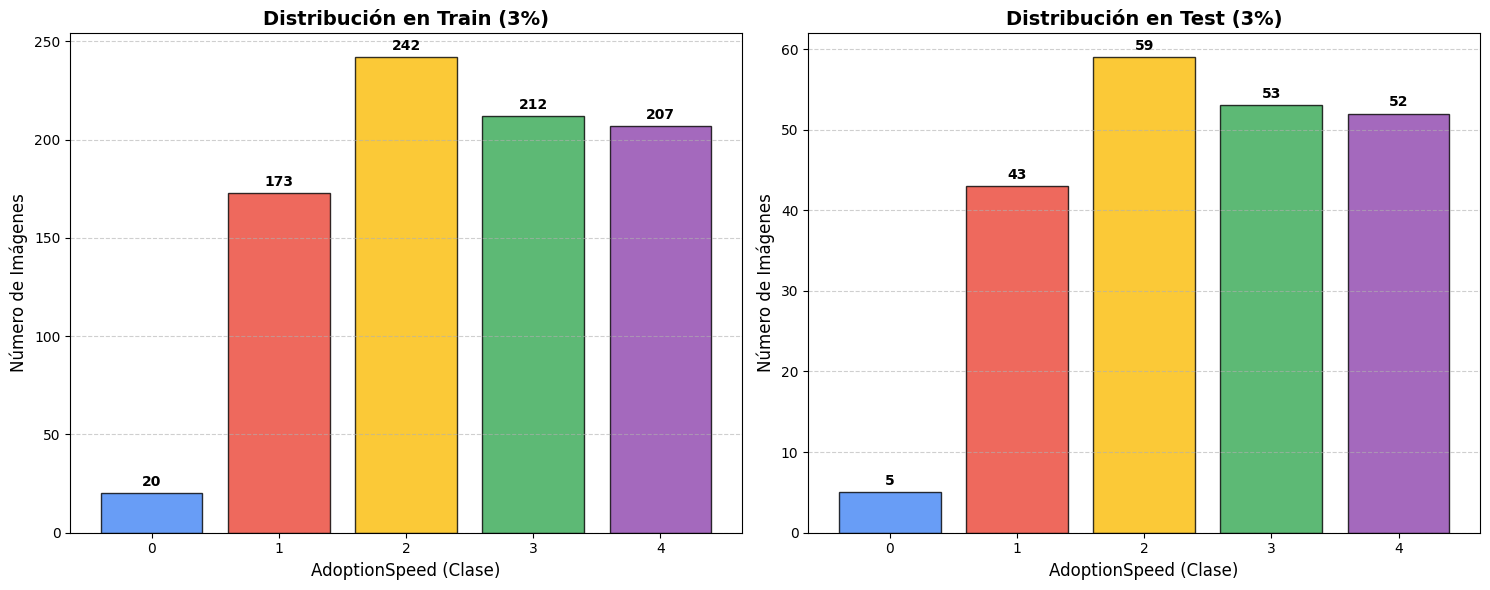

In [2]:
import matplotlib.pyplot as plt
import os
import seaborn as sns
import shutil
import random

def crear_y_graficar_mini_dataset2(porcentaje=0.02):
    base_dir = r'G:\Mi unidad\Mascotas'
    origen = os.path.join(base_dir, 'datos tratados')
    destino = os.path.join(base_dir, 'mini_dataset2')
    
    # 1. COMPROBAR SI EXISTE mini_dataset2
    if not os.path.exists(destino):
        print(f"📂 Creando '{destino}' seleccionando el {porcentaje*100}% de imágenes...")
        
        sets = ['Train', 'Test']
        clases = ['0', '1', '2', '3', '4']
        
        for s in sets:
            for c in clases:
                path_origen = os.path.join(origen, s, c)
                path_destino = os.path.join(destino, s, c)
                
                if os.path.exists(path_origen):
                    # Crear carpetas de destino
                    os.makedirs(path_destino, exist_ok=True)
                    
                    # Listar imágenes
                    imagenes = [f for f in os.listdir(path_origen) if os.path.isfile(os.path.join(path_origen, f))]
                    
                    # Calcular el 3% (mínimo 1 imagen si la carpeta no está vacía)
                    cantidad_a_copiar = max(1, int(len(imagenes) * porcentaje)) if imagenes else 0
                    
                    # Selección aleatoria
                    seleccion = random.sample(imagenes, cantidad_a_copiar)
                    
                    # Copiar archivos
                    for img in seleccion:
                        shutil.copy(os.path.join(path_origen, img), os.path.join(path_destino, img))
        print("✅ Proceso de copia finalizado.")
    else:
        print(f"ℹ️ La carpeta 'mini_dataset2' ya existe. Saltando creación.")

    # 2. FUNCIÓN DE GRÁFICO (tu código original modificado para apuntar a mini_dataset2)
    graficar_distribucion('mini_dataset2')

def graficar_distribucion(nombre_carpeta='mini_dataset2'):
    # Detección de ruta
    base_path_local = nombre_carpeta
    base_path_drive = os.path.join(r'G:\Mi unidad\Mascotas', nombre_carpeta)
    
    if os.path.exists(base_path_local):
        base_path = base_path_local
    elif os.path.exists(base_path_drive):
        base_path = base_path_drive
    else:
        print(f"❌ No se encuentra la carpeta '{nombre_carpeta}'")
        return

    print(f"📊 Analizando distribución en: {os.path.abspath(base_path)}")

    sets = ['Train', 'Test']
    clases = ['0', '1', '2', '3', '4']
    colores = ['#4285F4', '#EA4335', '#FBBC05', '#34A853', '#8E44AD']
    
    fig, ax = plt.subplots(1, 2, figsize=(15, 6)) 
    
    for i, s in enumerate(sets):
        counts = []
        for c in clases:
            path = os.path.join(base_path, s, c)
            if os.path.exists(path):
                counts.append(len([f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]))
            else:
                counts.append(0)
        
        bars = ax[i].bar(clases, counts, color=colores, edgecolor='black', alpha=0.8)
        ax[i].set_title(f'Distribución en {s} (3%)', fontsize=14, fontweight='bold')
        ax[i].set_xlabel('AdoptionSpeed (Clase)', fontsize=12)
        ax[i].set_ylabel('Número de Imágenes', fontsize=12)
        ax[i].grid(axis='y', linestyle='--', alpha=0.6)
        
        for bar in bars:
            height = bar.get_height()
            ax[i].annotate(f'{height}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()

# Ejecutar todo
crear_y_graficar_mini_dataset2()

c:\Users\Equipo\Desktop\Machine_DL\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



🚀 Iniciando Experimento: Batch Size = 4


Progreso Total B=4: 100%|██████████| 20/20 [08:35<00:00, 25.79s/it, Loss=0.0170, QWK=0.0782]



🚀 Iniciando Experimento: Batch Size = 8


Progreso Total B=8: 100%|██████████| 20/20 [08:22<00:00, 25.11s/it, Loss=0.0241, QWK=0.0627]



🚀 Iniciando Experimento: Batch Size = 16


Progreso Total B=16: 100%|██████████| 20/20 [08:08<00:00, 24.41s/it, Loss=0.0204, QWK=0.0646]


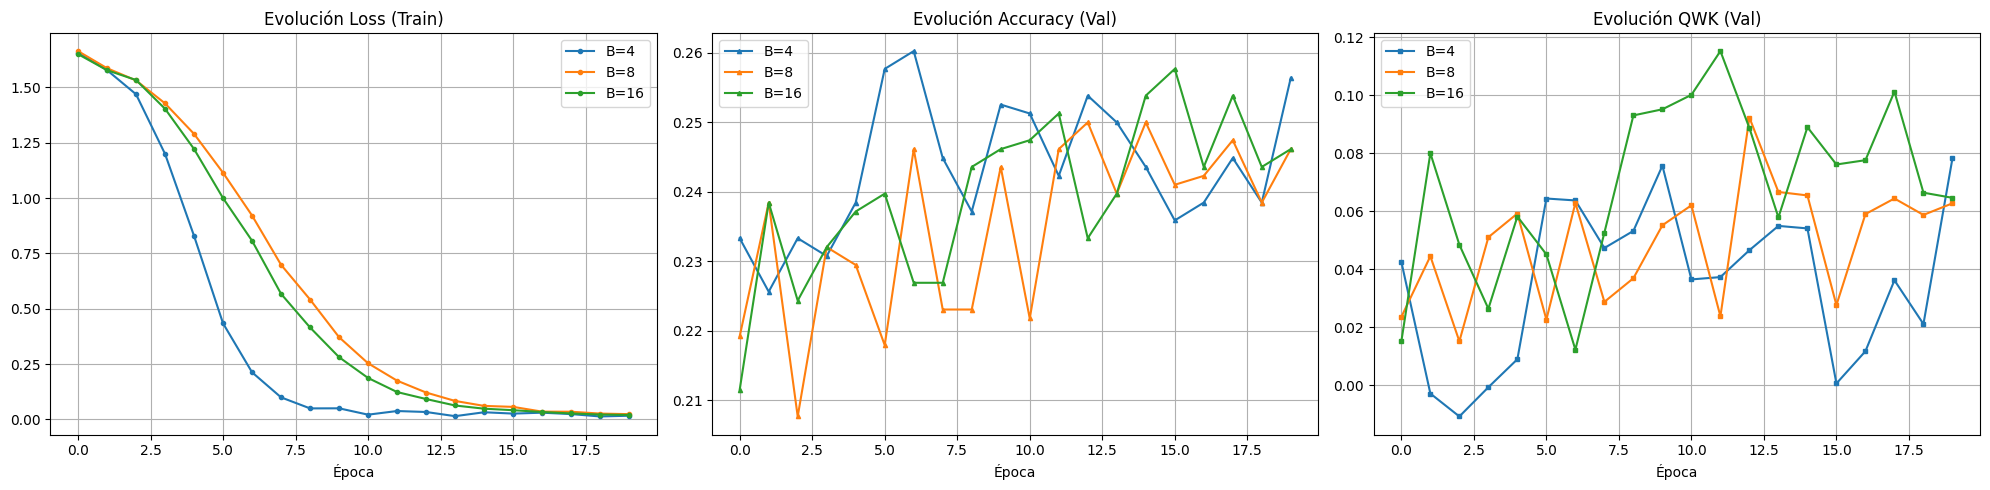


    RESUMEN FINAL: MEJOR RENDIMIENTO QWK POR BATCH SIZE (Cross Entropy)


,Batch Size,Mejor QWK,Época,Accuracy Asociado,Tiempo (s)
0,4,0.0782,20,0.2564,515.88
1,8,0.0922,13,0.2500,326.44
2,16,0.1152,12,0.2513,301.44


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, cohen_kappa_score, confusion_matrix
from tqdm.auto import tqdm

# ARQUITECTURA CNN
# Definimos una red convolucional sencilla para procesar las imágenes de mascotas
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 56 * 56, 128), nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.classifier(self.features(x))

# CONFIGURACIÓN DE DATOS
# Establecemos las rutas y transformaciones necesarias para el preprocesamiento
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_datos_drive = r'G:\Mi unidad\Mascotas\mini_dataset'
train_dir = os.path.join(base_datos_drive, 'Train')
test_dir = os.path.join(base_datos_drive, 'Test')

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)
val_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# EXPERIMENTO DE TAMAÑO DE BATCH CON CROSS ENTROPY
# Evaluamos cómo influye el tamaño de lote en la convergencia del modelo
def exp_batch_comparison():
    batch_sizes = [4, 8, 16]
    lr_fijo = 0.0001
    epochs = 20 
    
    # Historial para almacenar métricas por cada configuración de batch
    histories = {b: {"loss": [], "acc": [], "qwk": [], "times": []} for b in batch_sizes}
    all_cms = []

    for b_size in batch_sizes:
        print(f"\n🚀 Iniciando Experimento: Batch Size = {b_size}")
        train_loader = DataLoader(train_dataset, batch_size=b_size, shuffle=True)
        model = SimpleCNN().to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr_fijo)
        
        # Sustituimos la pérdida anterior por CrossEntropyLoss estándar
        criterion = nn.CrossEntropyLoss()
        
        start_t = time.time()
        pbar = tqdm(range(epochs), desc=f"Progreso Total B={b_size}")
        
        for epoch in pbar:
            # Entrenamiento
            model.train()
            epoch_loss = 0
            for imgs, labels in train_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                optimizer.zero_grad(set_to_none=True)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
            
            # Validación por época
            model.eval()
            val_preds, val_targets = [], []
            with torch.no_grad():
                for imgs, labels in val_loader:
                    imgs, labels = imgs.to(device), labels.to(device)
                    out = model(imgs)
                    # Obtenemos la clase con mayor probabilidad
                    val_preds.extend(torch.max(out, 1)[1].cpu().tolist())
                    val_targets.extend(labels.cpu().tolist())
            
            # Registro de métricas para análisis posterior
            avg_loss = epoch_loss / len(train_loader)
            current_acc = accuracy_score(val_targets, val_preds)
            current_qwk = cohen_kappa_score(val_targets, val_preds, weights='quadratic')
            
            histories[b_size]["loss"].append(avg_loss)
            histories[b_size]["acc"].append(current_acc)
            histories[b_size]["qwk"].append(current_qwk)
            histories[b_size]["times"].append(time.time() - start_t)
            
            pbar.set_postfix({'Loss': f'{avg_loss:.4f}', 'QWK': f'{current_qwk:.4f}'})
        
        all_cms.append(confusion_matrix(val_targets, val_preds))

    # VISUALIZACIÓN DE EVOLUCIÓN
    # Generamos las gráficas comparativas de rendimiento
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    for b in batch_sizes:
        axes[0].plot(histories[b]["loss"], label=f'B={b}', marker='o', markersize=3)
        axes[1].plot(histories[b]["acc"], label=f'B={b}', marker='^', markersize=3)
        axes[2].plot(histories[b]["qwk"], label=f'B={b}', marker='s', markersize=3)
    
    axes[0].set_title('Evolución Loss (Train)'); axes[0].set_xlabel('Época'); axes[0].legend(); axes[0].grid(True)
    axes[1].set_title('Evolución Accuracy (Val)'); axes[1].set_xlabel('Época'); axes[1].legend(); axes[1].grid(True)
    axes[2].set_title('Evolución QWK (Val)'); axes[2].set_xlabel('Época'); axes[2].legend(); axes[2].grid(True)
    plt.tight_layout()
    plt.show()

    # RESUMEN DE MEJORES RESULTADOS
    # Extraemos el punto de mayor rendimiento para cada tamaño de batch
    res_list = []
    for b in batch_sizes:
        qwk_hist = np.array(histories[b]["qwk"])
        acc_hist = np.array(histories[b]["acc"])
        time_hist = np.array(histories[b]["times"])
        
        idx_pico = np.argmax(qwk_hist)
        
        res_list.append({
            "Batch Size": b,
            "Mejor QWK": round(qwk_hist[idx_pico], 4),
            "Época": idx_pico + 1,
            "Accuracy Asociado": round(acc_hist[idx_pico], 4),
            "Tiempo (s)": round(time_hist[idx_pico], 2)
        })
    
    return pd.DataFrame(res_list)

# Ejecución y visualización del resumen final
df_resumen_batches = exp_batch_comparison()
print("\n" + "="*75)
print("    RESUMEN FINAL: MEJOR RENDIMIENTO QWK POR BATCH SIZE (Cross Entropy)")
print("="*75)
display(df_resumen_batches)


🚀 Evaluando Loss: CrossEntropy


Progreso CrossEntropy: 100%|██████████| 20/20 [09:36<00:00, 28.85s/it, Loss=0.0269, QWK=-0.0070]



🚀 Evaluando Loss: MSE (Ordinal)


Progreso MSE (Ordinal): 100%|██████████| 20/20 [09:22<00:00, 28.13s/it, Loss=1.7710, QWK=0.0061] 



🚀 Evaluando Loss: SoftKappa (QWK)


Progreso SoftKappa (QWK): 100%|██████████| 20/20 [09:47<00:00, 29.36s/it, Loss=0.3974, QWK=0.0534]


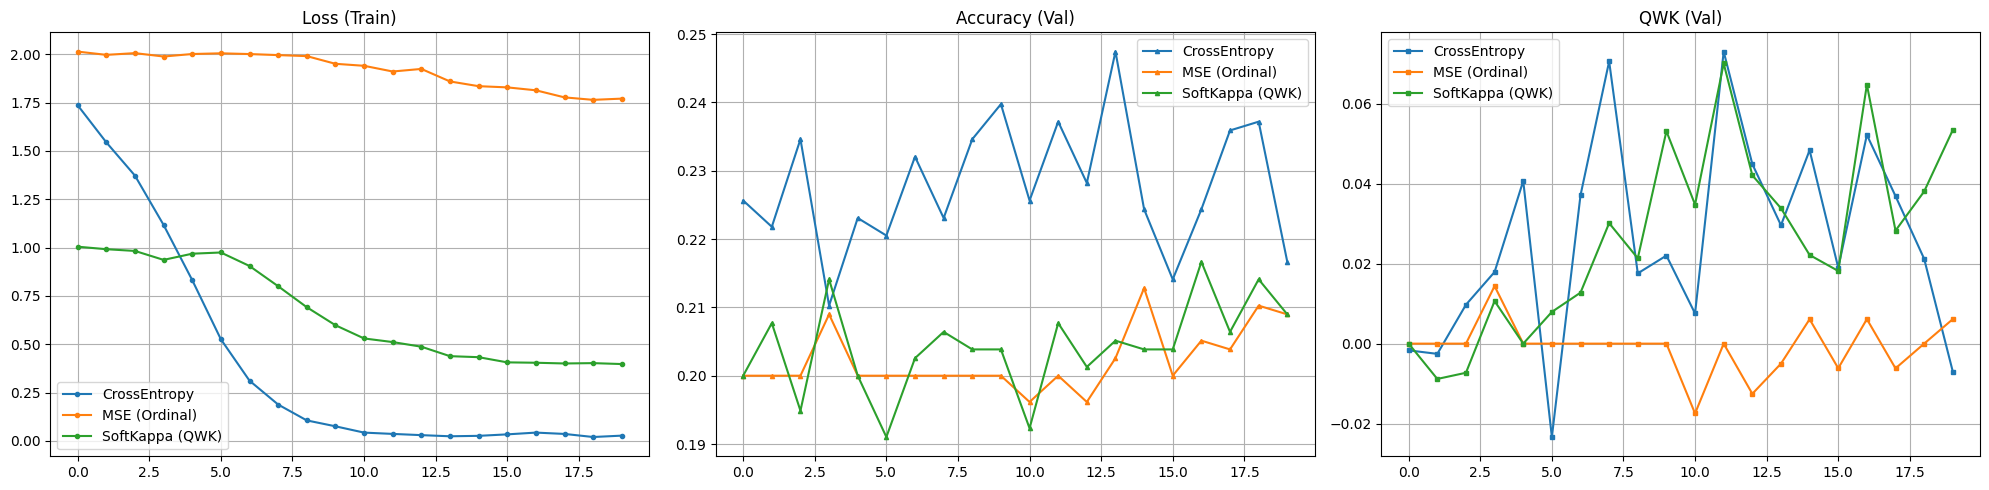

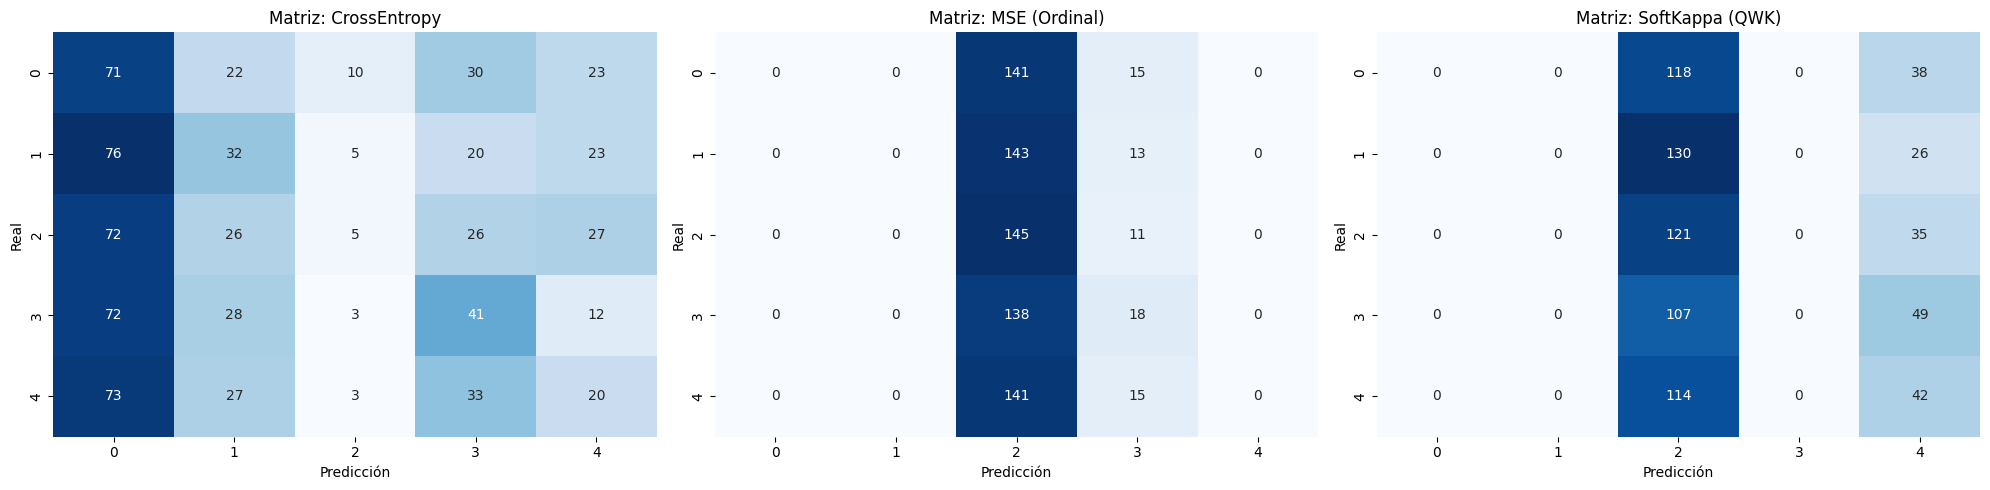


    COMPARATIVA FINAL DE RENDIMIENTO POR FUNCIÓN DE PÉRDIDA


,Loss Function,Mejor QWK,Época,Acc Asociado
0,CrossEntropy,0.0731,12,0.2372
1,MSE (Ordinal),0.0144,4,0.2090
2,SoftKappa (QWK),0.0701,12,0.2077


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, cohen_kappa_score, confusion_matrix
from tqdm.auto import tqdm

# FUNCIÓN DE PÉRDIDA: SOFT KAPPA LOSS (QWK)
# Penaliza los errores de clasificación basándose en la distancia al objetivo real
class QWKLoss(nn.Module):
    def __init__(self, num_classes=5):
        super(QWKLoss, self).__init__()
        self.num_classes = num_classes
        i, j = torch.meshgrid(torch.arange(num_classes), torch.arange(num_classes), indexing='ij')
        self.weights = (i - j).pow(2).float()

    def forward(self, logits, targets):
        preds = torch.softmax(logits, dim=1)
        targets_oh = F.one_hot(targets, self.num_classes).float()
        
        observed = torch.matmul(targets_oh.t(), preds)
        hist_actual = targets_oh.sum(dim=0, keepdim=True)
        hist_pred = preds.sum(dim=0, keepdim=True)
        expected = torch.matmul(hist_actual.t(), hist_pred) / (preds.size(0) + 1e-8)
        
        w = self.weights.to(logits.device)
        loss = torch.sum(w * observed) / (torch.sum(w * expected) + 1e-8)
        return loss

# ARQUITECTURA CNN
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 56 * 56, 128), nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.classifier(self.features(x))

# CONFIGURACIÓN DE DATOS
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_datos_drive = r'G:\Mi unidad\Mascotas\mini_dataset'
train_dir = os.path.join(base_datos_drive, 'Train')
test_dir = os.path.join(base_datos_drive, 'Test')

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)
# Parametros fijos según solicitud
train_loader_fijo = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# EXPERIMENTO COMPARATIVO
def exp_loss_comparison():
    loss_names = ['CrossEntropy', 'MSE (Ordinal)', 'SoftKappa (QWK)']
    lr_fijo = 0.0001
    epochs = 20 
    
    histories = {name: {"loss": [], "acc": [], "qwk": [], "times": []} for name in loss_names}
    confusion_matrices = {}

    for name in loss_names:
        print(f"\n🚀 Evaluando Loss: {name}")
        model = SimpleCNN().to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr_fijo)
        
        if name == 'CrossEntropy':
            criterion = nn.CrossEntropyLoss()
        elif name == 'MSE (Ordinal)':
            criterion = nn.MSELoss()
        else:
            criterion = QWKLoss(num_classes=5)
        
        start_t = time.time()
        pbar = tqdm(range(epochs), desc=f"Progreso {name}")
        
        for epoch in pbar:
            model.train()
            epoch_loss = 0
            for imgs, labels in train_loader_fijo:
                imgs, labels = imgs.to(device), labels.to(device)
                optimizer.zero_grad(set_to_none=True)
                outputs = model(imgs)
                
                if name == 'MSE (Ordinal)':
                    probs = torch.softmax(outputs, dim=1)
                    val_esperado = (probs * torch.arange(5).float().to(device)).sum(dim=1)
                    loss = criterion(val_esperado, labels.float())
                else:
                    loss = criterion(outputs, labels)
                    
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
            
            # Validación
            model.eval()
            val_preds, val_targets = [], []
            with torch.no_grad():
                for imgs, labels in val_loader:
                    imgs, labels = imgs.to(device), labels.to(device)
                    out = model(imgs)
                    val_preds.extend(torch.max(out, 1)[1].cpu().tolist())
                    val_targets.extend(labels.cpu().tolist())
            
            # Cálculo de métricas
            avg_loss = epoch_loss / len(train_loader_fijo)
            current_acc = accuracy_score(val_targets, val_preds)
            current_qwk = cohen_kappa_score(val_targets, val_preds, weights='quadratic')
            
            histories[name]["loss"].append(avg_loss)
            histories[name]["acc"].append(current_acc)
            histories[name]["qwk"].append(current_qwk)
            histories[name]["times"].append(time.time() - start_t)
            
            pbar.set_postfix({'Loss': f'{avg_loss:.4f}', 'QWK': f'{current_qwk:.4f}'})
        
        # Guardar matriz de confusión final de este modelo
        confusion_matrices[name] = confusion_matrix(val_targets, val_preds)

    # VISUALIZACIÓN DE CURVAS DE APRENDIZAJE
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    for name in loss_names:
        axes[0].plot(histories[name]["loss"], label=name, marker='o', markersize=3)
        axes[1].plot(histories[name]["acc"], label=name, marker='^', markersize=3)
        axes[2].plot(histories[name]["qwk"], label=name, marker='s', markersize=3)
    
    axes[0].set_title('Loss (Train)'); axes[0].legend(); axes[0].grid(True)
    axes[1].set_title('Accuracy (Val)'); axes[1].legend(); axes[1].grid(True)
    axes[2].set_title('QWK (Val)'); axes[2].legend(); axes[2].grid(True)
    plt.tight_layout()
    plt.show()

    # VISUALIZACIÓN DE MATRICES DE CONFUSIÓN
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    for i, name in enumerate(loss_names):
        sns.heatmap(confusion_matrices[name], annot=True, fmt='d', cmap='Blues', ax=axes[i], cbar=False)
        axes[i].set_title(f'Matriz: {name}')
        axes[i].set_xlabel('Predicción')
        axes[i].set_ylabel('Real')
    plt.tight_layout()
    plt.show()

    # RESUMEN DE RESULTADOS
    res_list = []
    for name in loss_names:
        qwk_hist = np.array(histories[name]["qwk"])
        acc_hist = np.array(histories[name]["acc"])
        idx_pico = np.argmax(qwk_hist)
        res_list.append({
            "Loss Function": name,
            "Mejor QWK": round(qwk_hist[idx_pico], 4),
            "Época": idx_pico + 1,
            "Acc Asociado": round(acc_hist[idx_pico], 4)
        })
    
    return pd.DataFrame(res_list)

# Lanzamiento del experimento
df_resumen_losses = exp_loss_comparison()
print("\n" + "="*75)
print("    COMPARATIVA FINAL DE RENDIMIENTO POR FUNCIÓN DE PÉRDIDA")
print("="*75)
display(df_resumen_losses)


🚀 Entrenando: CNN_Desde_Cero


CNN_Desde_Cero - Época 10: 100%|██████████| 49/49 [00:18<00:00,  2.71it/s]



🚀 Entrenando: Transfer_Learning


Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to C:\Users\Equipo/.cache\torch\hub\checkpoints\mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 21.4MB/s]
Transfer_Learning - Época 10: 100%|██████████| 49/49 [00:15<00:00,  3.10it/s]


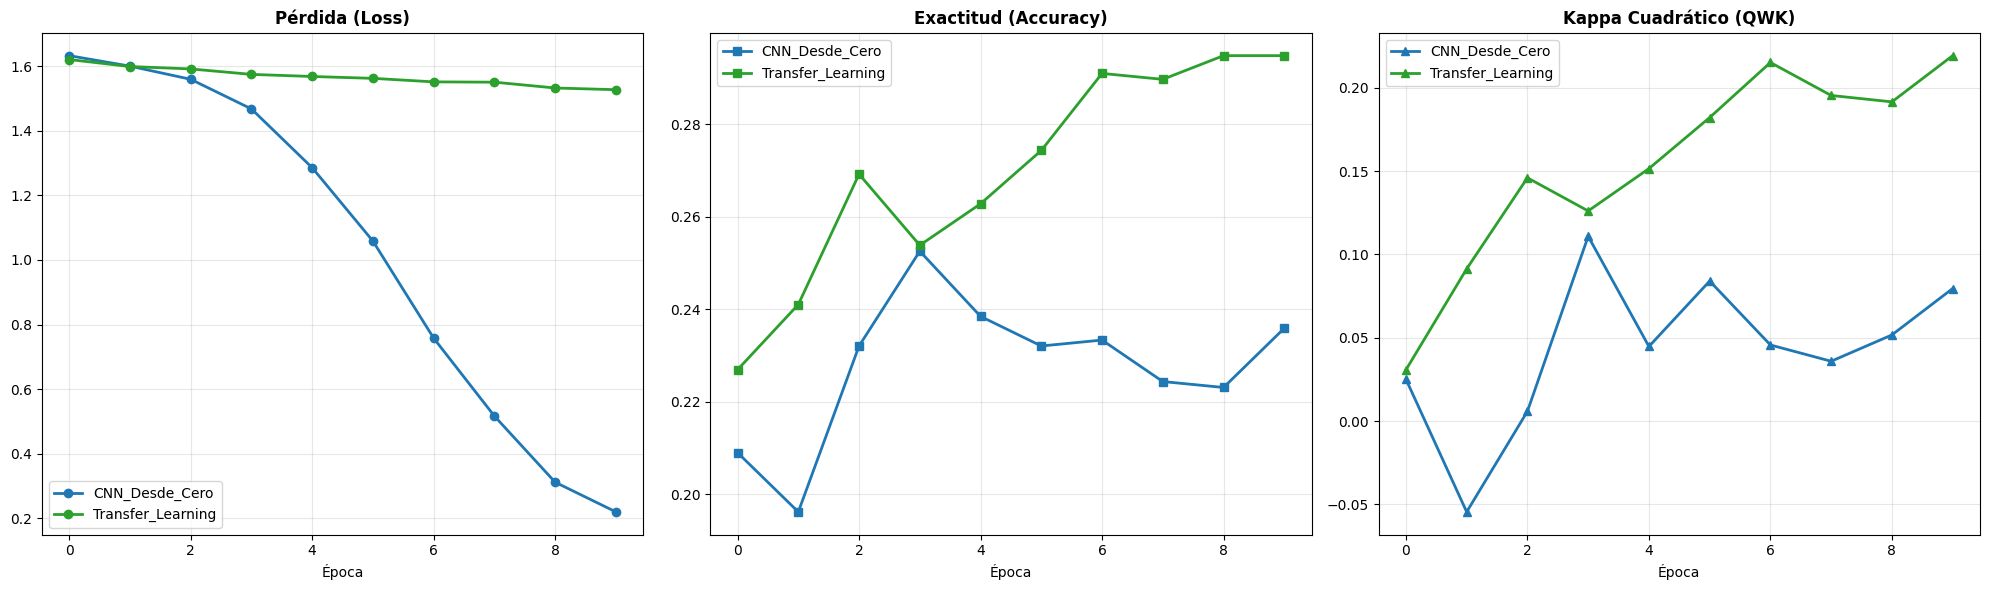

Modelo CNN_Desde_Cero -> Mejor QWK alcanzado: 0.1109
Modelo Transfer_Learning -> Mejor QWK alcanzado: 0.2193


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models
from sklearn.metrics import accuracy_score, cohen_kappa_score

# Arquitectura CNN básica creada desde cero
class PetNetScratch(nn.Module):
    def __init__(self, num_classes=5):
        super(PetNetScratch, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # 128 canales * 28 * 28 de resolución tras 3 MaxPool = 100,352 neuronas
            nn.Linear(128 * 28 * 28, 256), nn.ReLU(), nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.classifier(self.features(x))

# Función para implementar Transfer Learning con MobileNetV2
def get_transfer_model(num_classes=5):
    # Cargamos pesos pre-entrenados en ImageNet
    model = models.mobilenet_v2(weights='DEFAULT')
    # Congelamos las capas base para no destruir el conocimiento previo
    for param in model.parameters():
        param.requires_grad = False
    # Reemplazamos la última capa para nuestro número de clases de mascotas
    model.classifier[1] = nn.Linear(model.last_channel, num_classes)
    return model

# Configuración de entorno y directorios
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
folder_modelos = '../modelos'
if not os.path.exists(folder_modelos):
    os.makedirs(folder_modelos)

# Transformaciones estándar para modelos pre-entrenados (224x224)
transform_224 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Carga de datos (ajusta la ruta según tu estructura de carpetas)
base_datos_drive = r'G:\Mi unidad\Mascotas\mini_dataset'
train_dataset = datasets.ImageFolder(os.path.join(base_datos_drive, 'Train'), transform=transform_224)
val_dataset = datasets.ImageFolder(os.path.join(base_datos_drive, 'Test'), transform=transform_224)

# Cálculo de pesos para mitigar el desbalanceo de clases
targets = torch.tensor(train_dataset.targets)
class_count = torch.tensor([(targets == t).sum() for t in torch.unique(targets)])
weights = (1. / class_count.float()).to(device)

# Parámetros de entrenamiento
batch_size = 16
epochs = 10
modelos_a_evaluar = ["CNN_Desde_Cero", "Transfer_Learning"]
all_histories = {}
scaler = torch.amp.GradScaler('cuda') if torch.cuda.is_available() else None

# Ciclo de comparación de arquitecturas
for name in modelos_a_evaluar:
    print(f"\n🚀 Entrenando: {name}")
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    if name == "CNN_Desde_Cero":
        model = PetNetScratch(num_classes=5).to(device)
    else:
        model = get_transfer_model(num_classes=5).to(device)
        
    criterion = nn.CrossEntropyLoss(weight=weights)
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    
    historia = {"loss": [], "qwk": [], "acc": []}
    best_qwk = -1.0

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        for inputs, labels in tqdm(train_loader, desc=f"{name} - Época {epoch+1}"):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            # Uso de precisión mixta para acelerar el entrenamiento si hay GPU
            with torch.amp.autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            
            if scaler:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                optimizer.step()
                
            epoch_loss += loss.item()

        # Validación tras cada época
        model.eval()
        preds_list, labels_list = [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs.to(device))
                _, preds = torch.max(outputs, 1)
                preds_list.extend(preds.cpu().numpy())
                labels_list.extend(labels.numpy())

        # Cálculo de métricas
        acc = accuracy_score(labels_list, preds_list)
        qwk = cohen_kappa_score(labels_list, preds_list, weights='quadratic')
        
        historia["loss"].append(epoch_loss / len(train_loader))
        historia["acc"].append(acc)
        historia["qwk"].append(qwk)
        
        if qwk > best_qwk:
            best_qwk = qwk
            torch.save(model.state_dict(), os.path.join(folder_modelos, f'mejor_{name}.pth'))

    all_histories[name] = historia

# Visualización comparativa final (Se ha corregido el diccionario de colores)
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
colores = {"CNN_Desde_Cero": "#1f77b4", "Transfer_Learning": "#2ca02c"}

for name in modelos_a_evaluar:
    axes[0].plot(all_histories[name]["loss"], label=name, color=colores[name], lw=2, marker='o')
    axes[1].plot(all_histories[name]["acc"], label=name, color=colores[name], lw=2, marker='s')
    axes[2].plot(all_histories[name]["qwk"], label=name, color=colores[name], lw=2, marker='^')

titulos = ['Pérdida (Loss)', 'Exactitud (Accuracy)', 'Kappa Cuadrático (QWK)']
for i, ax in enumerate(axes):
    ax.set_title(titulos[i], fontweight='bold')
    ax.set_xlabel('Época')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('resultado_comparativo.png')
plt.show()

# Resumen de resultados en consola
for name in modelos_a_evaluar:
    max_qwk = max(all_histories[name]["qwk"])
    print(f"Modelo {name} -> Mejor QWK alcanzado: {max_qwk:.4f}")


🚀 Iniciando Experimento: Batch Size = 8


B8 - Época 10/10: 100%|██████████| 98/98 [00:22<00:00,  4.30it/s]



🚀 Iniciando Experimento: Batch Size = 16


B16 - Época 10/10: 100%|██████████| 49/49 [00:20<00:00,  2.45it/s]


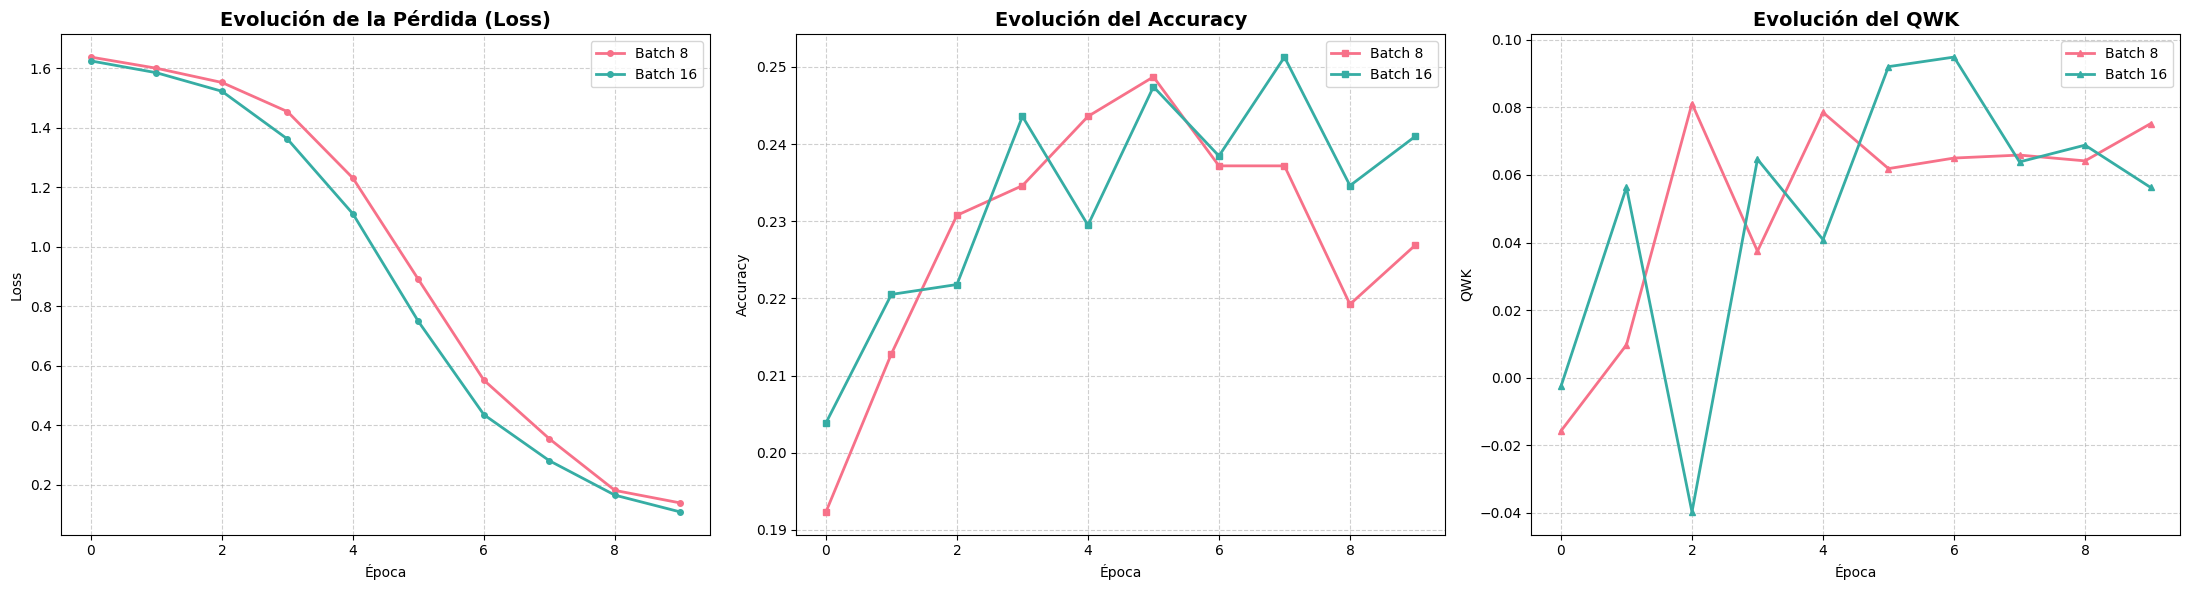


   RESUMEN FINAL: MEJOR RENDIMIENTO POR BATCH SIZE
   Batch Size  Mejor QWK  Época  Accuracy Asociado  Tiempo (s)
0           8     0.0811      3             0.2308      120.31
1          16     0.0949      7             0.2385      256.69


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.amp as amp
import os
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from sklearn.metrics import accuracy_score, cohen_kappa_score, confusion_matrix

# --- ARQUITECTURA SINCRONIZADA (Para 224x224) ---
class PetNetScratch(nn.Module):
    def __init__(self, num_classes=5):
        super(PetNetScratch, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 256), nn.ReLU(), nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.classifier(self.features(x))

# --- PREPARACIÓN DE DIRECTORIOS Y DATOS ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
folder_modelos = '../modelos'
if not os.path.exists(folder_modelos):
    os.makedirs(folder_modelos)

transform_224 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

base_datos_drive = r'G:\Mi unidad\Mascotas\mini_dataset'
train_dataset = datasets.ImageFolder(os.path.join(base_datos_drive, 'Train'), transform=transform_224)
val_dataset = datasets.ImageFolder(os.path.join(base_datos_drive, 'Test'), transform=transform_224)

targets = torch.tensor(train_dataset.targets)
class_count = torch.tensor([(targets == t).sum() for t in torch.unique(targets)])
weights = (1. / class_count.float()).to(device)

# --- EXPERIMENTO COMPARATIVO (BATCH 8 vs 16) ---
batch_sizes = [8, 16]
epochs = 10
all_histories = {}
resumen_final = []
scaler = amp.GradScaler('cuda')

for b_size in batch_sizes:
    print(f"\n🚀 Iniciando Experimento: Batch Size = {b_size}")
    
    train_loader = DataLoader(train_dataset, batch_size=b_size, shuffle=True, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, pin_memory=True)
    
    model = PetNetScratch(num_classes=5).to(device)
    criterion = nn.CrossEntropyLoss(weight=weights)
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    
    historia = {"loss": [], "qwk": [], "acc": [], "time": []}
    best_qwk_val = -1.0
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        for inputs, labels in tqdm(train_loader, desc=f"B{b_size} - Época {epoch+1}/{epochs}"):
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            
            optimizer.zero_grad(set_to_none=True)
            with amp.autocast('cuda'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            epoch_loss += loss.item()

        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                with amp.autocast('cuda'):
                    outputs = model(inputs.to(device, non_blocking=True))
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.numpy())

        current_acc = accuracy_score(all_labels, all_preds)
        current_qwk = cohen_kappa_score(all_labels, all_preds, weights='quadratic')
        
        historia["loss"].append(epoch_loss / len(train_loader))
        historia["acc"].append(current_acc)
        historia["qwk"].append(current_qwk)
        historia["time"].append(time.time() - start_time)

        if current_qwk > best_qwk_val:
            best_qwk_val = current_qwk
            torch.save(model.state_dict(), os.path.join(folder_modelos, f'mejor_modelo_B{b_size}.pth'))

    all_histories[b_size] = historia
    
    idx_mejor = np.argmax(historia["qwk"])
    resumen_final.append({
        "Batch Size": b_size,
        "Mejor QWK": round(historia["qwk"][idx_mejor], 4),
        "Época": idx_mejor + 1,
        "Accuracy Asociado": round(historia["acc"][idx_mejor], 4),
        "Tiempo (s)": round(historia["time"][idx_mejor], 2)
    })

# --- VISUALIZACIÓN HOLD ON (Superposición de curvas) ---
fig, axes = plt.subplots(1, 3, figsize=(22, 6))
# Se define un color para cada batch size presente en el experimento
palette = sns.color_palette("husl", len(batch_sizes))
colores_dinamicos = {b: palette[i] for i, b in enumerate(batch_sizes)}

for b in batch_sizes:
    axes[0].plot(all_histories[b]["loss"], label=f'Batch {b}', color=colores_dinamicos[b], lw=2, marker='o', markersize=4)
    axes[1].plot(all_histories[b]["acc"], label=f'Batch {b}', color=colores_dinamicos[b], lw=2, marker='s', markersize=4)
    axes[2].plot(all_histories[b]["qwk"], label=f'Batch {b}', color=colores_dinamicos[b], lw=2, marker='^', markersize=4)

titulos = ['Evolución de la Pérdida (Loss)', 'Evolución del Accuracy', 'Evolución del QWK']
y_labels = ['Loss', 'Accuracy', 'QWK']

for i, ax in enumerate(axes):
    ax.set_title(titulos[i], fontsize=14, fontweight='bold')
    ax.set_xlabel('Época')
    ax.set_ylabel(y_labels[i])
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

# --- TABLA DE RESUMEN FINAL ---
df_resumen = pd.DataFrame(resumen_final)
print("\n" + "="*75)
print("   RESUMEN FINAL: MEJOR RENDIMIENTO POR BATCH SIZE")
print("="*75)
print(df_resumen)


🚀 Iniciando Entrenamiento: Batch Size = 16


B16 - Época 10/10: 100%|██████████| 2678/2678 [19:11<00:00,  2.33it/s]


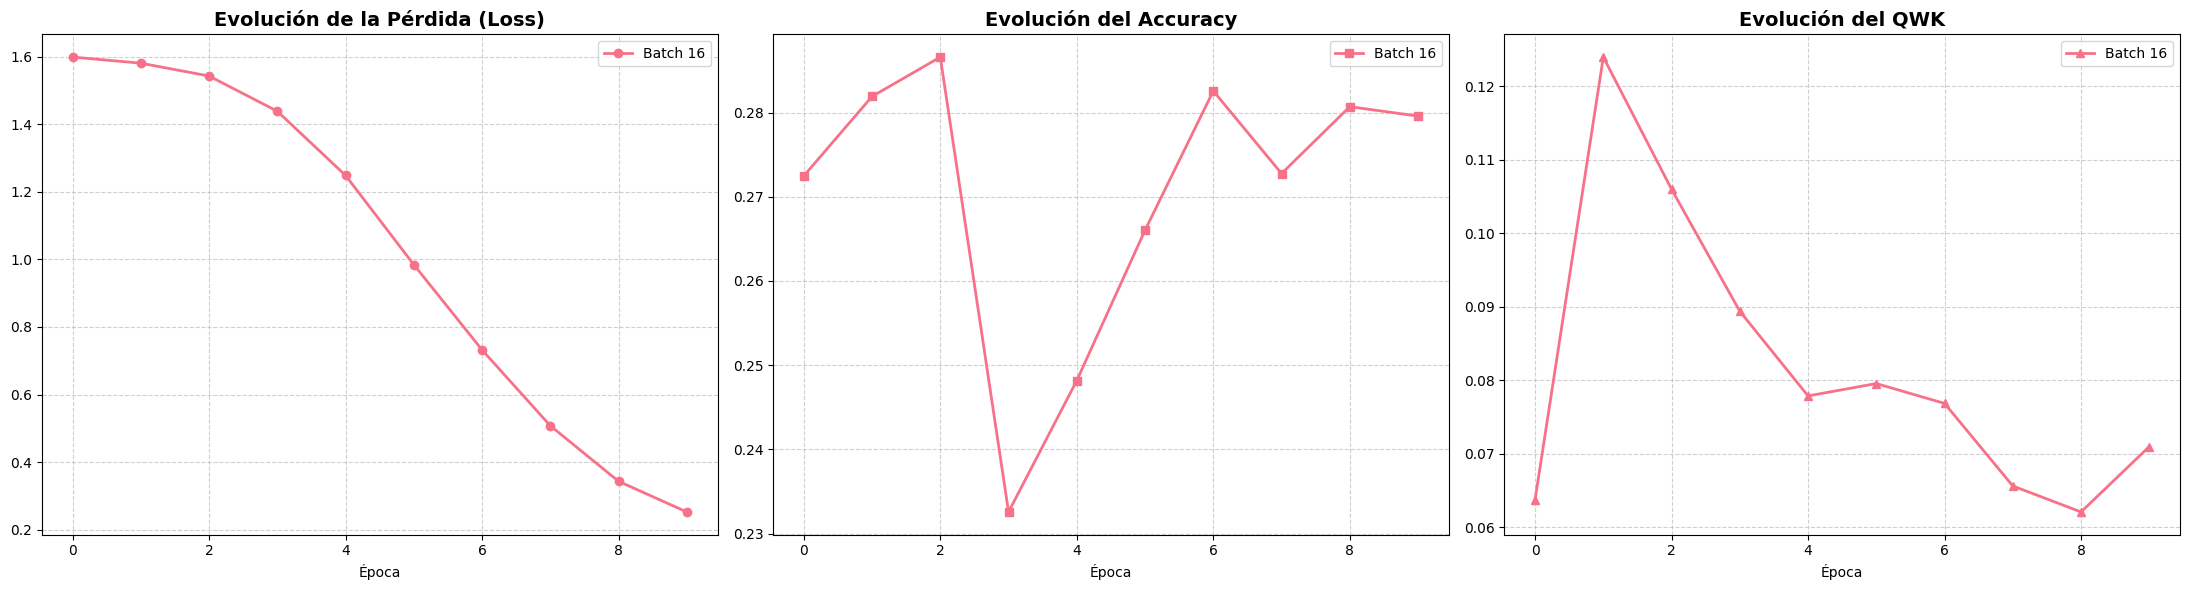

C:\Users\Equipo\AppData\Local\Temp\ipykernel_19952\4058752944.py:145: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(folder_mode

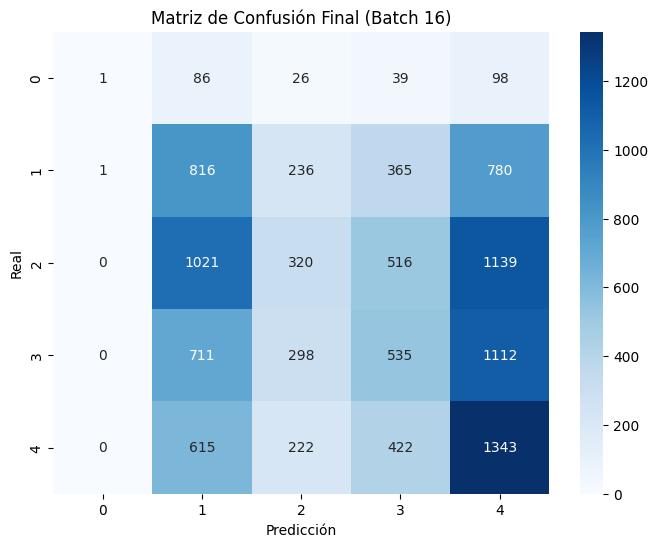


   RESUMEN FINAL: RENDIMIENTO BATCH SIZE 16
   Batch Size  Mejor QWK  Época  Accuracy Asociado  Tiempo (s)
0          16      0.124      2             0.2819     2764.61


In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.amp as amp
import os
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from sklearn.metrics import accuracy_score, cohen_kappa_score, confusion_matrix

# --- ARQUITECTURA SINCRONIZADA (Para 224x224) ---
class PetNetScratch(nn.Module):
    def __init__(self, num_classes=5):
        super(PetNetScratch, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 256), nn.ReLU(), nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.classifier(self.features(x))

# --- PREPARACIÓN DE DIRECTORIOS Y DATOS ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
folder_modelos = '../modelos'
if not os.path.exists(folder_modelos):
    os.makedirs(folder_modelos)

transform_224 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

base_datos_drive = r'G:\Mi unidad\Mascotas\datos tratados'
train_dataset = datasets.ImageFolder(os.path.join(base_datos_drive, 'Train'), transform=transform_224)
val_dataset = datasets.ImageFolder(os.path.join(base_datos_drive, 'Test'), transform=transform_224)

targets = torch.tensor(train_dataset.targets)
class_count = torch.tensor([(targets == t).sum() for t in torch.unique(targets)])
weights = (1. / class_count.float()).to(device)

# --- EXPERIMENTO (SOLO BATCH 16) ---
batch_sizes = [16]
epochs = 10
all_histories = {}
resumen_final = []
scaler = amp.GradScaler('cuda')

for b_size in batch_sizes:
    print(f"\n🚀 Iniciando Entrenamiento: Batch Size = {b_size}")
    
    train_loader = DataLoader(train_dataset, batch_size=b_size, shuffle=True, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, pin_memory=True)
    
    model = PetNetScratch(num_classes=5).to(device)
    criterion = nn.CrossEntropyLoss(weight=weights)
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    
    historia = {"loss": [], "qwk": [], "acc": [], "time": []}
    best_qwk_val = -1.0
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        for inputs, labels in tqdm(train_loader, desc=f"B{b_size} - Época {epoch+1}/{epochs}"):
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            
            optimizer.zero_grad(set_to_none=True)
            with amp.autocast('cuda'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            epoch_loss += loss.item()

        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                with amp.autocast('cuda'):
                    outputs = model(inputs.to(device, non_blocking=True))
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.numpy())

        current_acc = accuracy_score(all_labels, all_preds)
        current_qwk = cohen_kappa_score(all_labels, all_preds, weights='quadratic')
        
        historia["loss"].append(epoch_loss / len(train_loader))
        historia["acc"].append(current_acc)
        historia["qwk"].append(current_qwk)
        historia["time"].append(time.time() - start_time)

        if current_qwk > best_qwk_val:
            best_qwk_val = current_qwk
            torch.save(model.state_dict(), os.path.join(folder_modelos, f'mejor_modelo_B{b_size}.pth'))

    all_histories[b_size] = historia
    
    idx_mejor = np.argmax(historia["qwk"])
    resumen_final.append({
        "Batch Size": b_size,
        "Mejor QWK": round(historia["qwk"][idx_mejor], 4),
        "Época": idx_mejor + 1,
        "Accuracy Asociado": round(historia["acc"][idx_mejor], 4),
        "Tiempo (s)": round(historia["time"][idx_mejor], 2)
    })

# --- VISUALIZACIÓN DE MÉTRICAS ---
fig, axes = plt.subplots(1, 3, figsize=(22, 6))
palette = sns.color_palette("husl", len(batch_sizes))
colores_dinamicos = {b: palette[i] for i, b in enumerate(batch_sizes)}

for b in batch_sizes:
    axes[0].plot(all_histories[b]["loss"], label=f'Batch {b}', color=colores_dinamicos[b], lw=2, marker='o')
    axes[1].plot(all_histories[b]["acc"], label=f'Batch {b}', color=colores_dinamicos[b], lw=2, marker='s')
    axes[2].plot(all_histories[b]["qwk"], label=f'Batch {b}', color=colores_dinamicos[b], lw=2, marker='^')

titulos = ['Evolución de la Pérdida (Loss)', 'Evolución del Accuracy', 'Evolución del QWK']
for i, ax in enumerate(axes):
    ax.set_title(titulos[i], fontsize=14, fontweight='bold')
    ax.set_xlabel('Época')
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

# --- MATRIZ DE CONFUSIÓN (Usando el mejor modelo guardado) ---
model.load_state_dict(torch.load(os.path.join(folder_modelos, f'mejor_modelo_B16.pth')))
model.eval()
final_preds, final_labels = [], []

with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = model(inputs.to(device))
        _, preds = torch.max(outputs, 1)
        final_preds.extend(preds.cpu().numpy())
        final_labels.extend(labels.numpy())

cm = confusion_matrix(final_labels, final_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.title('Matriz de Confusión Final (Batch 16)')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

# --- TABLA DE RESUMEN FINAL ---
df_resumen = pd.DataFrame(resumen_final)
print("\n" + "="*75)
print("   RESUMEN FINAL: RENDIMIENTO BATCH SIZE 16")
print("="*75)
print(df_resumen)

c:\Users\Equipo\Desktop\Machine_DL\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



🚀 Evaluando Loss: CrossEntropy


Progreso CrossEntropy: 100%|██████████| 40/40 [12:40<00:00, 19.02s/it, Loss=0.0212, QWK=0.0667]



🚀 Evaluando Loss: SoftKappa (QWK)


Progreso SoftKappa (QWK): 100%|██████████| 40/40 [13:20<00:00, 20.01s/it, Loss=0.2138, QWK=0.0053] 


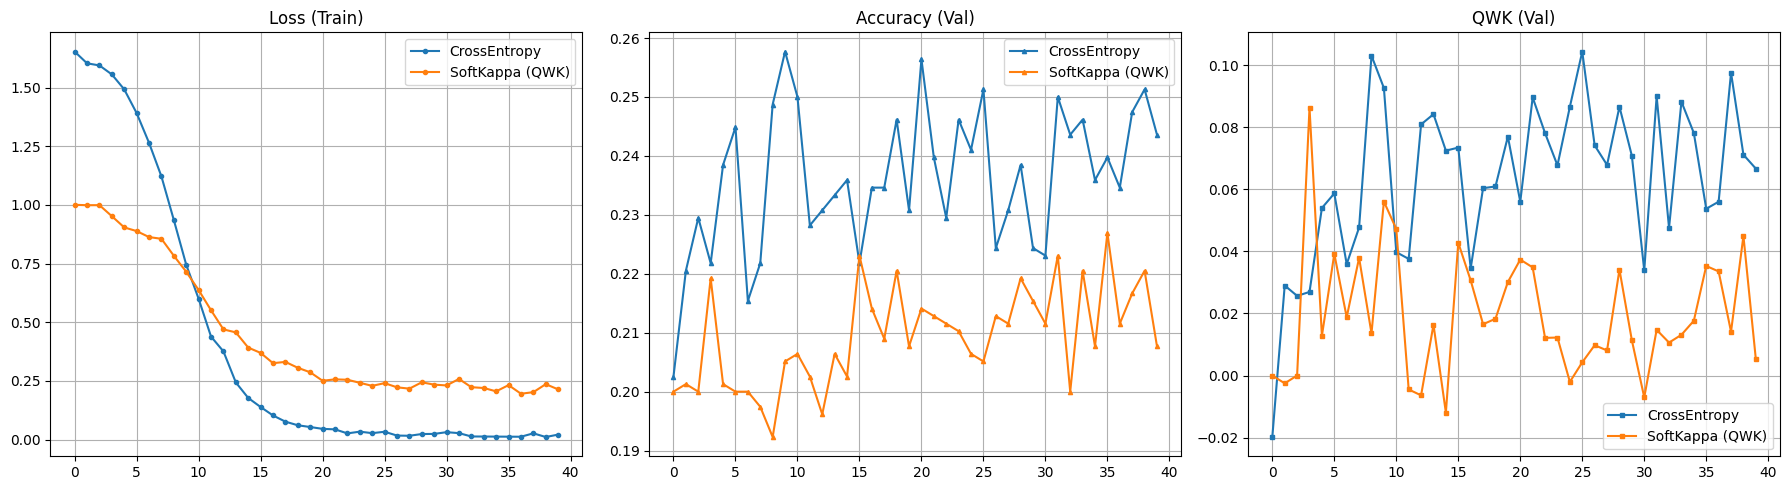

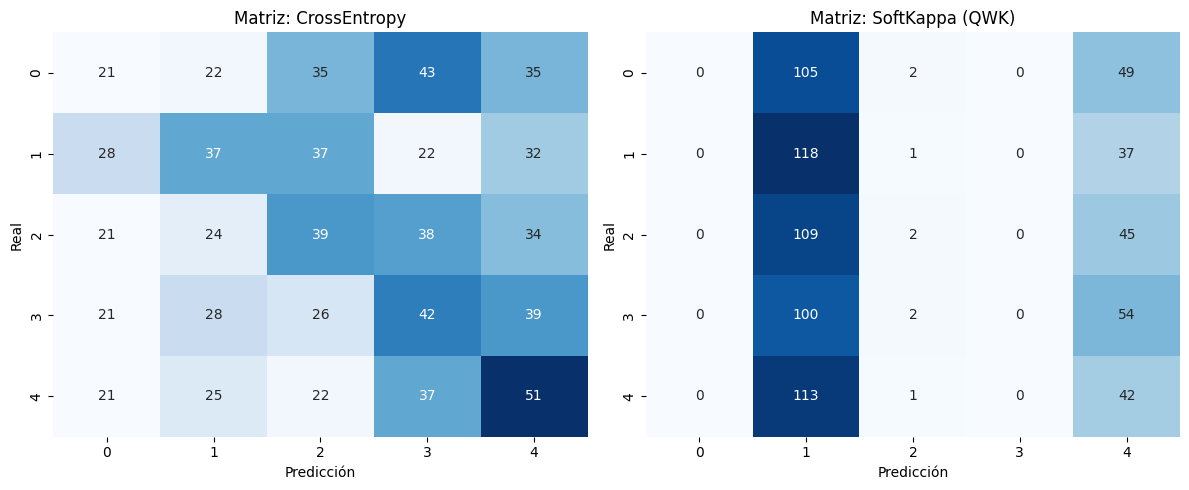


     COMPARATIVA FINAL DE RENDIMIENTO: CE vs SOFTKAPPA (40 ÉPOCAS)
     Loss Function  Mejor QWK  Época  Acc Asociado
0     CrossEntropy     0.1044     26        0.2513
1  SoftKappa (QWK)     0.0863      4        0.2192


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, cohen_kappa_score, confusion_matrix
from tqdm.auto import tqdm

# FUNCIÓN DE PÉRDIDA: SOFT KAPPA LOSS (QWK)
class QWKLoss(nn.Module):
    def __init__(self, num_classes=5):
        super(QWKLoss, self).__init__()
        self.num_classes = num_classes
        i, j = torch.meshgrid(torch.arange(num_classes), torch.arange(num_classes), indexing='ij')
        self.weights = (i - j).pow(2).float()

    def forward(self, logits, targets):
        preds = torch.softmax(logits, dim=1)
        targets_oh = F.one_hot(targets, self.num_classes).float()
        
        observed = torch.matmul(targets_oh.t(), preds)
        hist_actual = targets_oh.sum(dim=0, keepdim=True)
        hist_pred = preds.sum(dim=0, keepdim=True)
        expected = torch.matmul(hist_actual.t(), hist_pred) / (preds.size(0) + 1e-8)
        
        w = self.weights.to(logits.device)
        loss = torch.sum(w * observed) / (torch.sum(w * expected) + 1e-8)
        return loss

# ARQUITECTURA CNN
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 56 * 56, 128), nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.classifier(self.features(x))

# CONFIGURACIÓN DE DATOS
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_datos_drive = r'G:\Mi unidad\Mascotas\mini_dataset'
train_dir = os.path.join(base_datos_drive, 'Train')
test_dir = os.path.join(base_datos_drive, 'Test')

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

train_loader_fijo = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# EXPERIMENTO COMPARATIVO
def exp_loss_comparison():
    # Modificado: Solo dos funciones de pérdida
    loss_names = ['CrossEntropy', 'SoftKappa (QWK)']
    lr_fijo = 0.0001
    epochs = 40  # Modificado: 40 épocas
    
    histories = {name: {"loss": [], "acc": [], "qwk": [], "times": []} for name in loss_names}
    confusion_matrices = {}

    for name in loss_names:
        print(f"\n🚀 Evaluando Loss: {name}")
        model = SimpleCNN().to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr_fijo)
        
        if name == 'CrossEntropy':
            criterion = nn.CrossEntropyLoss()
        else:
            criterion = QWKLoss(num_classes=5)
        
        start_t = time.time()
        pbar = tqdm(range(epochs), desc=f"Progreso {name}")
        
        for epoch in pbar:
            model.train()
            epoch_loss = 0
            for imgs, labels in train_loader_fijo:
                imgs, labels = imgs.to(device), labels.to(device)
                optimizer.zero_grad(set_to_none=True)
                outputs = model(imgs)
                
                loss = criterion(outputs, labels)
                
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
            
            # Validación
            model.eval()
            val_preds, val_targets = [], []
            with torch.no_grad():
                for imgs, labels in val_loader:
                    imgs, labels = imgs.to(device), labels.to(device)
                    out = model(imgs)
                    val_preds.extend(torch.max(out, 1)[1].cpu().tolist())
                    val_targets.extend(labels.cpu().tolist())
            
            # Cálculo de métricas
            avg_loss = epoch_loss / len(train_loader_fijo)
            current_acc = accuracy_score(val_targets, val_preds)
            current_qwk = cohen_kappa_score(val_targets, val_preds, weights='quadratic')
            
            histories[name]["loss"].append(avg_loss)
            histories[name]["acc"].append(current_acc)
            histories[name]["qwk"].append(current_qwk)
            histories[name]["times"].append(time.time() - start_t)
            
            pbar.set_postfix({'Loss': f'{avg_loss:.4f}', 'QWK': f'{current_qwk:.4f}'})
        
        confusion_matrices[name] = confusion_matrix(val_targets, val_preds)

    # VISUALIZACIÓN DE CURVAS DE APRENDIZAJE
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    for name in loss_names:
        axes[0].plot(histories[name]["loss"], label=name, marker='o', markersize=3)
        axes[1].plot(histories[name]["acc"], label=name, marker='^', markersize=3)
        axes[2].plot(histories[name]["qwk"], label=name, marker='s', markersize=3)
    
    axes[0].set_title('Loss (Train)'); axes[0].legend(); axes[0].grid(True)
    axes[1].set_title('Accuracy (Val)'); axes[1].legend(); axes[1].grid(True)
    axes[2].set_title('QWK (Val)'); axes[2].legend(); axes[2].grid(True)
    plt.tight_layout()
    plt.show()

    # VISUALIZACIÓN DE MATRICES DE CONFUSIÓN (2 subplots ahora)
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    for i, name in enumerate(loss_names):
        sns.heatmap(confusion_matrices[name], annot=True, fmt='d', cmap='Blues', ax=axes[i], cbar=False)
        axes[i].set_title(f'Matriz: {name}')
        axes[i].set_xlabel('Predicción')
        axes[i].set_ylabel('Real')
    plt.tight_layout()
    plt.show()

    # RESUMEN DE RESULTADOS
    res_list = []
    for name in loss_names:
        qwk_hist = np.array(histories[name]["qwk"])
        acc_hist = np.array(histories[name]["acc"])
        idx_pico = np.argmax(qwk_hist)
        res_list.append({
            "Loss Function": name,
            "Mejor QWK": round(qwk_hist[idx_pico], 4),
            "Época": idx_pico + 1,
            "Acc Asociado": round(acc_hist[idx_pico], 4)
        })
    
    return pd.DataFrame(res_list)

# Lanzamiento del experimento
df_resumen_losses = exp_loss_comparison()
print("\n" + "="*75)
print("     COMPARATIVA FINAL DE RENDIMIENTO: CE vs SOFTKAPPA (40 ÉPOCAS)")
print("="*75)
print(df_resumen_losses)